In [1]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [2]:
!pip install pyngrok

In [3]:
!ngrok config add-authtoken 2jEbf2vy5sgqlmfFMxtbCU0YOTh_7xx12Nt5egP6Ds2kFV8zi

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
!pip install spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
!pip install nltk

In [5]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
import numpy as np
import random
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import datetime
import pandas as pd
import json
import matplotlib.pyplot as plt


In [23]:
# Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

NameError: name 'nltk' is not defined

This part of the notebook is mainly focussing on analysing the prompts given by the user to transfer it in a form of task we require. This is a small implementation using models like "en_core_web_lg" and using simple matching. Other robust implementations include using BERT for more clear understanding of the prompt.

In [7]:
task_types = [
    {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)},
    {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)},
    {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)},
    {'name': 'Documentation', 'skill_focus': [5, 6], 'duration_range': (1, 5), 'complexity_range': (1, 5)},
    {'name': 'Design', 'skill_focus': [2, 7], 'duration_range': (2, 6), 'complexity_range': (3, 7)},
    {'name': 'Testing', 'skill_focus': [1, 4], 'duration_range': (1, 4), 'complexity_range': (2, 6)},
    {'name': 'DevOps', 'skill_focus': [3, 6], 'duration_range': (1, 6), 'complexity_range': (3, 9)},
    {'name': 'Customer support', 'skill_focus': [5, 7], 'duration_range': (1, 3), 'complexity_range': (1, 7)},
]

class TaskNLP:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")
        self.skill_map = {
            0: ["coding", "programming", "debugging", "development"],
            1: ["testing", "qa", "quality assurance", "verification"],
            2: ["design", "ui", "ux", "user experience"],
            3: ["analysis", "analytics", "data processing", "reporting"],
            4: ["review", "code review"],
            5: ["documentation", "writing", "technical writing"],
            6: ["devops", "cloud", "infrastructure"],
            7: ["customer", "user", "support"]
        }
        self._setup_entities()

    # def _calculate_skill_strength(self, skill_term, doc):
    #     skill_value = 0.6
    #     for token in doc:
    #         if token.text.lower() == skill_term.lower():
    #             if token.dep_ == "amod" or token.dep_ == "advmod":
    #                 if token.head.text.lower() in ["strong", "expert", "advanced"]:
    #                     skill_value = 0.9
    #                 elif token.head.text.lower() in ["basic", "beginner"]:
    #                     skill_value = 0.4

    #             for child in token.children:
    #                 if child.dep_ in ["acomp", "xcomp"] and child.pos_ == "VERB":
    #                     if child.text.lower() in ["need", "require", "must"]:
    #                         skill_value = max(skill_value, 0.8)

    #     return skill_value

    def _calculate_skill_strength(self, skill_term, doc):
        skill_value = 0.6

        for token in doc:
            if token.text.lower() == skill_term.lower():
                for child in token.children:
                    if child.dep_ in ["amod", "advmod"]:
                        if child.text.lower() in ["strong", "expert", "advanced"]:
                            skill_value = max(skill_value, 0.9)
                        elif child.text.lower() in ["basic", "beginner"]:
                            skill_value = min(skill_value, 0.4)

                if token.dep_ in ["nsubj", "attr", "dobj"]:
                    for child in token.head.children:
                        if child.dep_ in ["acomp", "amod"]:
                            if child.text.lower() in ["advanced", "strong", "expert"]:
                                skill_value = max(skill_value, 0.9)
                            elif child.text.lower() in ["basic", "beginner"]:
                                skill_value = min(skill_value, 0.4)

                for ancestor in token.ancestors:
                    if ancestor.pos_ == "VERB" and ancestor.lemma_ in ["require", "need", "must", "expect", "prefer"]:
                        skill_value = max(skill_value, 0.8)

        return skill_value


    def _setup_entities(self):
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = []
        for skill_id, terms in self.skill_map.items():
            patterns.extend([self.nlp.make_doc(term) for term in terms])
        self.matcher.add("SKILL", patterns)

        task_patterns = []
        for task_type in task_types:
            task_patterns.append(self.nlp.make_doc(task_type['name'].lower()))
        self.task_matcher = PhraseMatcher(self.nlp.vocab)
        self.task_matcher.add("TASK_TYPE", task_patterns)

        ruler = self.nlp.add_pipe("entity_ruler", before="ner")
        patterns = [
            {"label": "PRIORITY", "pattern": [{"LOWER": {"IN": ["high", "medium", "low"]}}]},

            {"label": "DURATION", "pattern": [{"LIKE_NUM": True}, {"LOWER": {"IN": ["hour", "hours", "hr", "hrs"]}}]},
            {"label": "DURATION", "pattern": [{"LOWER": {"IN": ["around", "about", "approximately"]}}, {"LIKE_NUM": True}, {"LOWER": {"IN": ["hours", "hrs"]}}]},
            {"label": "DURATION", "pattern": [{"LOWER": "duration"}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},

            {"label": "DEADLINE", "pattern": [{"LIKE_NUM": True}, {"LOWER": {"IN": ["day", "days"]}}]},
            {"label": "DEADLINE", "pattern": [{"LOWER": "deadline"}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},

            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["complexity", "difficulty", "level"]}}, {"LIKE_NUM": True}]},
            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["high", "medium", "low"]}}, {"LOWER": {"IN": ["complexity", "difficulty"]}}]},
            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["complexity"]}}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},
        ]
        ruler.add_patterns(patterns)

    def _map_skill(self, token_text):
        token_doc = self.nlp(token_text)
        similarities = []
        for skill_id, terms in self.skill_map.items():
            max_sim = max(
                token_doc.similarity(self.nlp(term))
                for term in terms
            )
            similarities.append((skill_id, max_sim))

        return max(similarities, key=lambda x: x[1])[0]

    def parse_text(self, text):
        doc = self.nlp(text.lower())
        result = {
            "task_type": None,
            "skill_requirements": np.zeros(8),
            "priority": 5,
            "duration": None,
            "deadline": None,
            "complexity": 5
        }

        task_matches = self.task_matcher(doc)
        for match_id, start, end in task_matches:
            span = doc[start:end]
            for task_type in task_types:
                if task_type['name'].lower() == span.text.lower():
                    result["task_type"] = task_type
                    break

        for skill_id, terms in self.skill_map.items():
            for term in terms:
                if term in text.lower():
                    strength = self._calculate_skill_strength(term, doc)
                    result["skill_requirements"][skill_id] = max(
                        result["skill_requirements"][skill_id],
                        strength
                    )

        if result["task_type"]:
            for skill in result["task_type"]['skill_focus']:
                if result["skill_requirements"][skill] == 0:
                    result["skill_requirements"][skill] = 0.6

        for i in range(len(result["skill_requirements"])):
            if result["skill_requirements"][i] == 0:
                result["skill_requirements"][i] = round(np.random.uniform(0.0, 0.4),2)

        for ent in doc.ents:
            if ent.label_ == "PRIORITY":
                result["priority"] = {"high": 9, "medium": 6, "low": 3}.get(ent.text.lower(), 5)
            elif ent.label_ == "DURATION":
                result["duration"] = float(ent.text.split()[0])
            elif ent.label_ == "DEADLINE":
                result["deadline"] = int(ent.text.split()[0])
            elif ent.label_ == "COMPLEXITY":
                text = ent.text.lower()
                if "high" in text:
                    result["complexity"] = 9
                elif "medium" in text:
                    result["complexity"] = 6
                elif "low" in text:
                    result["complexity"] = 3
                else:
                    for token in ent:
                        if token.like_num:
                            result["complexity"] = int(token.text)
                            break

        if not result["duration"]:
            if result["task_type"]:
                result["duration"] = np.random.uniform(*result["task_type"]["duration_range"])
            else:
                result["duration"] = 4.0
        if not result["deadline"]:
            result["deadline"] = 7

        return result


    def parse_texts(self, texts):
        results = []
        for text in texts:
            result = self.parse_text(text)
            results.append(result)
        return results


Testing with a single task

In [8]:
nlp = TaskNLP()
text = "1. We urgently need advanced cloud infrastructure setup with basic documentation skills."
result = nlp.parse_text(text)
print(result)

{'task_type': {'name': 'Documentation', 'skill_focus': [5, 6], 'duration_range': (1, 5), 'complexity_range': (1, 5)}, 'skill_requirements': array([0.2 , 0.19, 0.08, 0.32, 0.2 , 0.8 , 0.8 , 0.2 ]), 'priority': 5, 'duration': 2.771287374949754, 'deadline': 7, 'complexity': 5}


Testing with multiple tasks

In [9]:
texts = [
    "I need someone to do a bug fix with high complexity.",
    "We require a feature development with medium complexity.",
    "Please perform a code review with low priority.",
    "Need to do a bug fix."
]

results = nlp.parse_texts(texts)
for i, result in enumerate(results):
    print(f"Text {i+1}: {texts[i]}")
    print(result)
    print()

Text 1: I need someone to do a bug fix with high complexity.
{'task_type': {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)}, 'skill_requirements': array([0.6 , 0.6 , 0.31, 0.19, 0.04, 0.27, 0.02, 0.06]), 'priority': 5, 'duration': 3.456552716196956, 'deadline': 7, 'complexity': 9}

Text 2: We require a feature development with medium complexity.
{'task_type': {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)}, 'skill_requirements': array([0.8 , 0.13, 0.6 , 0.6 , 0.22, 0.26, 0.07, 0.27]), 'priority': 5, 'duration': 6.12431815024421, 'deadline': 7, 'complexity': 6}

Text 3: Please perform a code review with low priority.
{'task_type': {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)}, 'skill_requirements': array([0.6 , 0.6 , 0.27, 0.13, 0.6 , 0.12, 0.06, 0.22]), 'priority': 3, 'duration': 1.4481326170754527, 'deadline': 7, 'com

This part of the notebook focuses on training Deep Q-Network for scheduling the tasks using a specified reward system.

The DQNSchedulerAgent uses reinforcement learning to make optimal task assignment decisions:
- Uses a multi-layer neural network to approximate the Q-function for decision making
- Implements experience replay with batch training for more stable learning
- Features gradient accumulation and double DQN architecture for better convergence
- Balances exploration vs. exploitation with a decaying epsilon-greedy policy
- Tracks key performance metrics during training for visualization

In [10]:
# Constants
NUM_EMPLOYEES = 10
NUM_SKILLS = 8
MAX_TASKS_PER_DAY = 25
BATCH_SIZE = 64
EPISODES = 1
ACCUMULATION_STEPS = 16
PRIORITY_WEIGHTS = {1: 0.1, 2: 0.2, 3: 0.3, 4: 0.5, 5: 0.7, 6: 1.0, 7: 1.5, 8: 2.0, 9: 3.0, 10: 5.0}

class DQNSchedulerAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        self.predict_fn = self._create_predict_function()
        self.target_predict_fn = self._create_target_predict_function()

        self.task_assignments = {}
        self.training_history = {
            'episode_rewards': [],
            'completion_rates': [],
            'high_priority_rates': [],
            'employee_utilization': [],
            'avg_skill_match': []
        }

    def _build_model(self):
        """Build a neural network for decision making with additional layers for complexity"""
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber_loss', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def _create_predict_function(self):
        """Create optimized prediction function with reduced retracing"""
        @tf.function(reduce_retracing=True)
        def predict_fn(states):
            return self.model(states, training=False)
        return predict_fn

    def _create_target_predict_function(self):
        """Create optimized target prediction function with reduced retracing"""
        @tf.function(reduce_retracing=True)
        def predict_target_fn(states):
            return self.target_model(states, training=False)
        return predict_target_fn

    def update_target_model(self):
        """Copy weights from model to target_model"""
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluation=False):
        """
        Choose action based on current state

        Args:
            state: Current state vector
            evaluation: If True, uses greedy policy (no exploration)
        """
        if not evaluation and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        act_values = self.predict_fn(state_tensor).numpy()
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """Train the model using experience replay with optimized batching and prioritized sampling"""
        if len(self.memory) < batch_size:
            return

        memory_size = len(self.memory)
        recent_size = min(memory_size // 2, 1000)
        recent_sample_count = min(int(batch_size * 0.7), recent_size)

        recent_samples = random.sample(list(self.memory)[-recent_size:], recent_sample_count)
        random_samples = random.sample(list(self.memory), int(batch_size * 0.3))
        minibatch = recent_samples + random_samples

        states = np.vstack([sample[0] for sample in minibatch])
        actions = np.array([sample[1] for sample in minibatch])
        rewards = np.array([sample[2] for sample in minibatch])
        next_states = np.vstack([sample[3] for sample in minibatch])
        dones = np.array([sample[4] for sample in minibatch])

        states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        targets = self.predict_fn(states_tensor).numpy()
        next_targets = self.target_predict_fn(next_states_tensor).numpy()
        next_actions = np.argmax(self.predict_fn(next_states_tensor).numpy(), axis=1)

        for i in range(len(minibatch)):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * next_targets[i, next_actions[i]]

        accumulated_grads = None

        for step in range(0, batch_size, ACCUMULATION_STEPS):
            end_idx = min(step + ACCUMULATION_STEPS, batch_size)
            batch_states = states_tensor[step:end_idx]
            batch_targets = targets[step:end_idx]

            with tf.GradientTape() as tape:
                predictions = self.model(batch_states, training=True)
                error = batch_targets - predictions
                quadratic = tf.minimum(tf.abs(error), 1.0)
                linear = tf.abs(error) - quadratic
                loss = tf.reduce_mean(0.5 * tf.square(quadratic) + linear)

            grads = tape.gradient(loss, self.model.trainable_variables)

            if accumulated_grads is None:
                accumulated_grads = grads
            else:
                accumulated_grads = [accumulated_grad + grad for accumulated_grad, grad in zip(accumulated_grads, grads)]

            if (step + ACCUMULATION_STEPS >= batch_size) or (end_idx == batch_size):
                normalized_grads = [grad / (end_idx - step) for grad in accumulated_grads]
                normalized_grads, _ = tf.clip_by_global_norm(normalized_grads, 5.0)

                self.model.optimizer.apply_gradients(zip(normalized_grads, self.model.trainable_variables))
                accumulated_grads = None

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load model weights"""
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        """Save model weights"""
        self.model.save_weights(name)

    def save_full_model(self, name):
        """Save complete model architecture and weights"""
        self.model.save(name)

    def record_assignment(self, task_id, employee_id=None, metadata=None):
        """Record which employee is assigned to which task with additional metadata"""
        assignment = {"timestamp": datetime.datetime.now().isoformat()}

        if metadata:
            assignment.update(metadata)

        if employee_id is not None:
            assignment["employee_id"] = employee_id
            assignment["status"] = "assigned"
        else:
            assignment["status"] = "rejected"

        self.task_assignments[task_id] = assignment

    def get_assignment_summary(self):
        """Return a summary of task assignments with detailed metrics"""
        assigned_tasks = {task_id: details for task_id, details in self.task_assignments.items()
                         if details.get("status") == "assigned"}

        rejected_tasks = {task_id: details for task_id, details in self.task_assignments.items()
                          if details.get("status") == "rejected"}
        employee_assignments = {}
        for task_id, details in assigned_tasks.items():
            emp_id = details.get("employee_id")
            if emp_id not in employee_assignments:
                employee_assignments[emp_id] = []
            employee_assignments[emp_id].append(task_id)

        workload_distribution = {}
        for emp_id, tasks in employee_assignments.items():
            workload_distribution[emp_id] = len(tasks)

        skill_utilization = {}
        for task_id, details in assigned_tasks.items():
            if "skill_match_score" in details:
                skill_score = details["skill_match_score"]
                if "skill_utilization" not in skill_utilization:
                    skill_utilization["avg_skill_match"] = []
                skill_utilization["avg_skill_match"].append(skill_score)

        if "avg_skill_match" in skill_utilization:
            skill_utilization["avg_skill_match"] = sum(skill_utilization["avg_skill_match"]) / len(skill_utilization["avg_skill_match"])

        return {
            "employee_assignments": employee_assignments,
            "assigned_tasks": assigned_tasks,
            "rejected_tasks": rejected_tasks,
            "workload_distribution": workload_distribution,
            "skill_utilization": skill_utilization
        }

    def assign_batch_tasks(self, tasks, employees, day_of_week):
        """
        Assign multiple tasks in batch mode

        Args:
            tasks: List of tasks to be assigned
            employees: List of employee dictionaries
            day_of_week: Current day of week (0-6)

        Returns:
            dict: Assignment results for each task
        """
        results = {}

        employees_copy = [employee.copy() for employee in employees]
        for employee in employees_copy:
            employee['assigned_tasks'] = []

        for task in tasks:
            employee_id, reward, metadata = self._get_best_employee_for_task(task, employees_copy, day_of_week)

            if employee_id is not None:
                employees_copy[employee_id]['current_workload'] += task['duration']
                employees_copy[employee_id]['current_fatigue'] += task['complexity'] * employees_copy[employee_id]['fatigue_factor']
                employees_copy[employee_id]['assigned_tasks'].append(task['id'])

                results[task['id']] = {
                    "status": "assigned",
                    "employee_id": employee_id,
                    "reward": reward,
                    **metadata
                }
                self.record_assignment(task['id'], employee_id, metadata)
            else:
                results[task['id']] = {
                    "status": "rejected",
                    "reason": "No suitable employee available or rejected by model",
                    "reward": reward,
                    **metadata
                }

                self.record_assignment(task['id'], None, {**metadata, "reason": "No suitable employee or rejected"})

        return results

    def assign_single_task(self, task, employees, day_of_week):
        """
        Determine the best employee for a single task

        Parameters:
        task (dict): Task to be assigned
        employees (list): List of employee dictionaries
        day_of_week (int): Current day of week (0-6)

        Returns:
        tuple: (assigned_employee_id, reward, metadata) or (None, rejection_reward, metadata) if rejected
        """
        return self._get_best_employee_for_task(task, employees, day_of_week)

    def _get_best_employee_for_task(self, task, employees, day_of_week):
        """
        Helper function to find the best employee for a task

        Returns:
        tuple: (best_employee_id, reward, metadata) or (None, rejection_reward, metadata)
        """
        best_action = None
        best_score = float('-inf')
        best_employee_idx = None

        employee_states = []
        employee_idxs = []

        for employee_idx, employee in enumerate(employees):
            if employee['availability'][day_of_week] <= employee['current_workload']:
                continue

            if employee['current_fatigue'] > employee.get('fatigue_threshold', 8.0):
                continue

            state = create_state_vector(employee, task, day_of_week)
            state = np.reshape(state, [1, self.state_size])

            employee_states.append(state)
            employee_idxs.append(employee_idx)

        if not employee_states:
            deadline_urgency = calculate_deadline_urgency(task['deadline'])
            rejection_reward = -1 * PRIORITY_WEIGHTS.get(task['priority'], 1.0) * deadline_urgency

            metadata = {
                "task_id": task['id'],
                "task_priority": task['priority'],
                "task_deadline": task['deadline'],
                "deadline_urgency": deadline_urgency,
                "reason": "No available employees"
            }

            return None, rejection_reward, metadata

        states_tensor = tf.convert_to_tensor(np.vstack(employee_states), dtype=tf.float32)
        predictions = self.predict_fn(states_tensor).numpy()

        for i, emp_idx in enumerate(employee_idxs):
            for action in range(self.action_size):
                if predictions[i, action] > best_score:
                    best_score = predictions[i, action]
                    best_action = action
                    best_employee_idx = emp_idx

        employee = employees[best_employee_idx]
        skill_match = calculate_skill_match(employee['skills'], task['skill_requirements'])

        metadata = {
            "task_id": task['id'],
            "task_priority": task['priority'],
            "task_deadline": task['deadline'],
            "skill_match_score": skill_match,
            "expected_quality": calculate_expected_quality(skill_match, employee['current_fatigue']),
            "action_q_value": best_score
        }

        if best_action < NUM_EMPLOYEES:
            reward = calculate_reward(employee, task, 'assign', skill_match)
            metadata["action"] = "assign"
            return best_employee_idx, reward, metadata
        else:
            reward = calculate_reward(employee, task, 'reject', skill_match)
            metadata["action"] = "reject"
            return None, reward, metadata

    def track_training_metrics(self, episode, total_reward, completion_rate, high_priority_rate,
                              employee_utilization, avg_skill_match):
        """Track metrics during training for visualization later"""
        self.training_history['episode_rewards'].append(total_reward)
        self.training_history['completion_rates'].append(completion_rate)
        self.training_history['high_priority_rates'].append(high_priority_rate)
        self.training_history['employee_utilization'].append(employee_utilization)
        self.training_history['avg_skill_match'].append(avg_skill_match)

    def save_training_history(self, filename):
        """Save training metrics to a file"""
        with open(filename, 'w') as f:
            json.dump(self.training_history, f)

    def plot_training_metrics(self, save_path=None):
        """Plot training metrics"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))

        axes[0, 0].plot(self.training_history['episode_rewards'])
        axes[0, 0].set_title('Episode Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Total Reward')

        axes[0, 1].plot(self.training_history['completion_rates'], label='All Tasks')
        axes[0, 1].plot(self.training_history['high_priority_rates'], label='High Priority Tasks')
        axes[0, 1].set_title('Completion Rates')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Completion Rate (%)')
        axes[0, 1].legend()

        axes[1, 0].plot(self.training_history['employee_utilization'])
        axes[1, 0].set_title('Employee Utilization')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Avg. Utilization (%)')

        axes[1, 1].plot(self.training_history['avg_skill_match'])
        axes[1, 1].set_title('Average Skill Match')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Avg. Skill Match Score')

        episodes = range(len(self.training_history['episode_rewards']))
        epsilon_values = [1.0 * (self.epsilon_decay ** episode) for episode in episodes]
        epsilon_values = [max(e, self.epsilon_min) for e in epsilon_values]

        axes[2, 0].plot(epsilon_values)
        axes[2, 0].set_title('Exploration Rate (Epsilon)')
        axes[2, 0].set_xlabel('Episode')
        axes[2, 0].set_ylabel('Epsilon')

        axes[2, 1].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

The TaskScheduler tries to simulate a realistic work environment with diverse employees and varying tasks:

- Employees have different skill sets (specialists and generalists), varying availability patterns, fatigue thresholds, and seniority levels
- Tasks have different priorities, deadlines, complexity levels, and skill requirements across different domains
- The environment tracks metrics like completion rates, employee utilization, and overdue tasks

In [11]:
class TaskScheduler:
    """Realistic task scheduler environment"""
    def __init__(self):
        """Initialize the task scheduler with employees and tasks"""
        self.employees = self._generate_employees()
        self.tasks = self._generate_tasks(100)
        self.day = 0
        self.calendar = {}
        self.performance_metrics = {
            'completed_tasks': 0,
            'rejected_tasks': 0,
            'overdue_tasks': 0,
            'avg_completion_time': [],
            'employee_utilization': {}
        }

    def _generate_employees(self):
        """Generate realistic employees with varying skills and attributes"""
        employees = []
        availability_patterns = [
            [8, 8, 8, 8, 8, 0, 0],
            [8, 8, 8, 8, 8, 4, 0],
            [0, 8, 8, 8, 8, 8, 0],
            [8, 8, 8, 8, 0, 0, 0],
            [6, 6, 6, 6, 6, 0, 0],
            [10, 10, 10, 10, 0, 0, 0],
            [8, 8, 0, 8, 8, 8, 0],
            [6, 6, 6, 6, 6, 6, 0],
        ]

        for i in range(NUM_EMPLOYEES):
            pattern_weights = [0.4, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]
            pattern_idx = np.random.choice(len(availability_patterns), p=pattern_weights)

            is_specialist = np.random.random() < 0.6

            skills = np.zeros(NUM_SKILLS)
            if is_specialist:
                num_specialties = np.random.randint(1, 4)
                specialty_skills = np.random.choice(NUM_SKILLS, num_specialties, replace=False)

                for skill in specialty_skills:
                    skills[skill] = np.random.uniform(0.7, 1.0)

                for skill in range(NUM_SKILLS):
                    if skill not in specialty_skills:
                        skills[skill] = np.random.uniform(0.1, 0.5)
            else:
                for skill in range(NUM_SKILLS):
                    skills[skill] = np.random.uniform(0.4, 0.8)

            is_senior = np.random.random() < 0.3
            if is_senior:
                skills = np.minimum(skills * 1.3, 1.0)

            fatigue_factor = np.random.uniform(0.8, 1.2)
            fatigue_threshold = 10.0 if is_senior else 8.0

            employees.append({
                'id': i,
                'skills': skills,
                'availability': availability_patterns[pattern_idx],
                'current_workload': 0,
                'current_fatigue': 0,
                'fatigue_factor': fatigue_factor,
                'fatigue_threshold': fatigue_threshold,
                'is_senior': is_senior,
                'completed_tasks': 0,
                'total_work_hours': 0
            })

        return employees

    def _generate_tasks(self, num_tasks):
        """Generate a realistic set of tasks with varying attributes"""
        tasks = []
        task_types = [
            {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)},
            {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)},
            {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)},
            {'name': 'Documentation', 'skill_focus': [5, 6], 'duration_range': (1, 5), 'complexity_range': (1, 5)},
            {'name': 'Design', 'skill_focus': [2, 7], 'duration_range': (2, 6), 'complexity_range': (3, 7)},
            {'name': 'Testing', 'skill_focus': [1, 4], 'duration_range': (1, 4), 'complexity_range': (2, 6)},
            {'name': 'DevOps', 'skill_focus': [3, 6], 'duration_range': (1, 6), 'complexity_range': (3, 9)},
            {'name': 'Customer support', 'skill_focus': [5, 7], 'duration_range': (1, 3), 'complexity_range': (1, 7)},
        ]

        for i in range(num_tasks):
            task_type = random.choice(task_types)
            skill_requirements = np.zeros(NUM_SKILLS)

            for skill in task_type['skill_focus']:
                skill_requirements[skill] = np.random.uniform(0.6, 1.0)

            for skill in range(NUM_SKILLS):
                if skill not in task_type['skill_focus']:
                    if np.random.random() < 0.3:
                        skill_requirements[skill] = np.random.uniform(0.1, 0.5)

            duration = np.random.randint(*task_type['duration_range'])

            complexity = np.random.randint(*task_type['complexity_range']) / 10.0
            priority_roll = np.random.random()
            if priority_roll < 0.1:
                priority = np.random.randint(8, 11)
            elif priority_roll < 0.4:
                priority = np.random.randint(5, 8)
            else:
                priority = np.random.randint(1, 5)

            deadline_base = max(1, 10 - priority)
            deadline_variation = np.random.randint(0, 5)
            deadline = deadline_base + deadline_variation

            tasks.append({
                'id': i,
                'type': task_type['name'],
                'skill_requirements': skill_requirements,
                'duration': duration,
                'complexity': complexity,
                'priority': priority,
                'deadline': deadline,
                'status': 'pending',
                'assigned_to': None,
                'created_day': 0,
                'completed_day': None
            })

        return tasks

    def generate_daily_tasks(self, day, base_count=10, variation=5):
        """Generate new tasks for a given day with realistic distribution"""
        day_of_week = day % 7

        if day_of_week == 5:
            task_multiplier = 0.5
        elif day_of_week == 6:
            task_multiplier = 0.3
        else:
            if day_of_week == 0:
                task_multiplier = 1.3
            elif day_of_week == 1:
                task_multiplier = 1.2
            else:
                task_multiplier = 1.0

        num_new_tasks = int(base_count * task_multiplier + random.randint(-variation, variation))
        num_new_tasks = max(1, num_new_tasks)

        current_task_id = len(self.tasks)
        new_tasks = []

        for i in range(num_new_tasks):
            task = self._generate_tasks(1)[0]
            task['id'] = current_task_id + i
            task['created_day'] = day
            new_tasks.append(task)

        self.tasks.extend(new_tasks)
        return new_tasks

    def step_day(self):
        """Advance the simulation by one day"""
        self.day += 1
        day_of_week = self.day % 7
        new_tasks = self.generate_daily_tasks(self.day)

        for task in self.tasks:
            if task['status'] == 'assigned':
                employee = self.employees[task['assigned_to']]

                if task['assigned_day'] < self.day:
                    task['status'] = 'completed'
                    task['completed_day'] = self.day
                    self.performance_metrics['completed_tasks'] += 1
                    employee['completed_tasks'] += 1

        for task in self.tasks:
            if task['status'] == 'pending' and task['deadline'] < self.day:
                task['status'] = 'overdue'
                self.performance_metrics['overdue_tasks'] += 1

        for employee in self.employees:
            employee['current_workload'] = 0
            employee['current_fatigue'] *= 0.7

        return day_of_week, new_tasks

Some helper functions required

In [12]:
def calculate_skill_match(employee_skills, task_skill_requirements):
    """
    Calculate how well an employee's skills match the task requirements

    Returns:
    float: 0.0-1.0 skill match score where 1.0 is perfect match
    """
    if sum(task_skill_requirements) == 0:
        return 1.0

    match_score = 0.0
    requirement_sum = sum(task_skill_requirements)

    for i in range(len(employee_skills)):
        if task_skill_requirements[i] > 0:
            weight = task_skill_requirements[i] / requirement_sum
            coverage = min(employee_skills[i] / task_skill_requirements[i], 1.0)
            match_score += weight * coverage

    return match_score

def calculate_expected_quality(skill_match, employee_fatigue):
    """Calculate expected quality of work based on skill match and fatigue"""
    quality = skill_match * (1.0 - (employee_fatigue / 10.0))
    return max(0.3, min(quality, 1.0))

def calculate_deadline_urgency(deadline):
    """Calculate urgency factor based on task deadline"""
    if deadline <= 1:
        return 2.0
    elif deadline <= 3:
        return 1.5
    elif deadline <= 5:
        return 1.2
    else:
        return 1.0

def calculate_reward(employee, task, action, skill_match):
    """
    Calculate reward for a given task assignment or rejection

    Parameters:
    employee (dict): Employee details
    task (dict): Task details
    action (str): Either 'assign' or 'reject'
    skill_match (float): Skill match score

    Returns:
    float: Calculated reward
    """
    priority_weight = PRIORITY_WEIGHTS.get(task['priority'], 1.0)
    deadline_urgency = calculate_deadline_urgency(task['deadline'])

    if action == 'assign':
        base_reward = 1.0
        priority_factor = priority_weight * deadline_urgency
        skill_factor = skill_match
        fatigue_penalty = min(1.0, employee['current_fatigue'] / employee['fatigue_threshold']) * 0.5
        reward = base_reward * priority_factor * skill_factor * (1.0 - fatigue_penalty)
        return reward

    else:
        rejection_penalty = -0.5 * priority_weight * deadline_urgency
        if skill_match < 0.3:
            rejection_penalty *= (skill_match / 0.3)
        if employee['current_fatigue'] > employee['fatigue_threshold'] * 0.8:
            fatigue_factor = min(1.0, employee['current_fatigue'] / employee['fatigue_threshold'])
            rejection_penalty *= (1.0 - fatigue_factor * 0.5)
        return rejection_penalty

def create_state_vector(employee, task, day_of_week):
    """
    Create a state vector that represents the current state for decision making

    Parameters:
    employee (dict): Employee details
    task (dict): Task details
    day_of_week (int): Current day of week (0-6)

    Returns:
    numpy.array: State vector
    """
    state = []
    state.append(employee['current_workload'] / 8.0)
    state.append(employee['current_fatigue'] / 10.0)
    state.append(employee['availability'][day_of_week] / 10.0)
    state.append(1.0 if employee['is_senior'] else 0.0)

    for skill in employee['skills']:
        state.append(skill)

    state.append(task['duration'] / 8.0)
    state.append(task['complexity'])
    state.append(task['priority'] / 10.0)
    state.append(min(1.0, 5.0 / task['deadline']))

    for skill_req in task['skill_requirements']:
        state.append(skill_req)
    for d in range(7):
        state.append(1.0 if d == day_of_week else 0.0)

    return np.array(state)


Actual training Loop where the integration has happened between all the parts of DQNetwork.

The training proceeds through multiple episodes, where each episode simulates 30 days of task assignments:

- For each day, the environment generates new tasks with varying priorities and requirements
- The agent evaluates each task against available employees, calculating skill match scores

For each potential assignment, the agent:
- Creates a state vector combining employee and task attributes
- Uses its neural network to predict the value of assigning or rejecting the task
- Takes action based on the epsilon-greedy policy (balancing exploration and exploitation)
- Receives rewards based on task priority, skill match, and employee fatigue
- Stores experiences in memory for later batch training


Periodically, the agent:

- Updates its target network to stabilize learning
- Evaluates performance without exploration
- Saves the best model based on total reward
- Tracks and visualizes key metrics like completion rates and employee utilization

In [13]:
def train_scheduler_agent(episodes=EPISODES, evaluation_frequency=10):
    """
    Train the DQN agent for task scheduling

    Parameters:
    episodes (int): Number of episodes to train
    evaluation_frequency (int): Frequency of evaluation runs

    Returns:
    DQNSchedulerAgent: Trained agent
    """
    env = TaskScheduler()
    sample_employee = env.employees[0]
    sample_task = env.tasks[0]
    sample_state = create_state_vector(sample_employee, sample_task, 0)
    state_size = len(sample_state)

    action_size = NUM_EMPLOYEES + 1
    agent = DQNSchedulerAgent(state_size, action_size)

    best_reward = float('-inf')
    best_weights_path = "best_scheduler.weights.h5"

    for episode in range(episodes):
        print(f"Episode {episode+1}/{episodes}")

        env = TaskScheduler()
        total_reward = 0
        tasks_completed = 0
        high_priority_tasks_completed = 0
        high_priority_tasks_total = 0

        for day in range(30):
            day_of_week, new_tasks = env.step_day()
            available_tasks = [task for task in env.tasks if task['status'] == 'pending']

            high_priority_tasks = [task for task in available_tasks if task['priority'] >= 7]
            high_priority_tasks_total += len(high_priority_tasks)

            available_tasks = sorted(available_tasks, key=lambda x: (-x['priority'], x['deadline']))
            daily_tasks = available_tasks[:MAX_TASKS_PER_DAY]
            prev_employee_states = [emp.copy() for emp in env.employees]

            for task in daily_tasks:
                task_state = []
                action_rewards = []

                for emp_idx, employee in enumerate(env.employees):
                    if employee['availability'][day_of_week] <= employee['current_workload']:
                        continue

                    state = create_state_vector(employee, task, day_of_week)
                    state = np.reshape(state, [1, state_size])

                    action = agent.act(state)
                    skill_match = calculate_skill_match(employee['skills'], task['skill_requirements'])

                    if action < NUM_EMPLOYEES:
                        reward = calculate_reward(employee, task, 'assign', skill_match)

                        employee['current_workload'] += task['duration']
                        employee['current_fatigue'] += task['complexity'] * employee['fatigue_factor']
                        employee['total_work_hours'] += task['duration']

                        task['status'] = 'assigned'
                        task['assigned_to'] = emp_idx
                        task['assigned_day'] = day

                        tasks_completed += 1
                        if task['priority'] >= 7:
                            high_priority_tasks_completed += 1
                    else:
                        reward = calculate_reward(employee, task, 'reject', skill_match)

                    total_reward += reward

                    next_state = create_state_vector(employee, task, day_of_week)
                    next_state = np.reshape(next_state, [1, state_size])
                    done = True

                    agent.memorize(state[0], action, reward, next_state[0], done)

                    metadata = {
                        "task_id": task['id'],
                        "task_priority": task['priority'],
                        "skill_match_score": skill_match,
                        "day": day,
                        "day_of_week": day_of_week
                    }

                    if action < NUM_EMPLOYEES:
                        agent.record_assignment(task['id'], emp_idx, metadata)
                    else:
                        agent.record_assignment(task['id'], None, metadata)

            if len(agent.memory) > BATCH_SIZE:
                agent.replay(BATCH_SIZE)

        completion_rate = tasks_completed / len(env.tasks) if env.tasks else 0
        high_priority_rate = high_priority_tasks_completed / high_priority_tasks_total if high_priority_tasks_total else 1.0

        total_utilization = 0
        for employee in env.employees:
            available_hours = sum(employee['availability'])
            utilization = employee['total_work_hours'] / available_hours if available_hours > 0 else 0
            total_utilization += utilization

        avg_utilization = total_utilization / len(env.employees) if env.employees else 0

        assignment_summary = agent.get_assignment_summary()
        avg_skill_match = assignment_summary.get('skill_utilization', {}).get('avg_skill_match', 0)

        agent.track_training_metrics(episode, total_reward, completion_rate, high_priority_rate,
                                   avg_utilization, avg_skill_match)

        print(f"  Total reward: {total_reward:.2f}")
        print(f"  Completion rate: {completion_rate:.2%}")
        print(f"  High priority completion rate: {high_priority_rate:.2%}")
        print(f"  Employee utilization: {avg_utilization:.2%}")

        if episode % 5 == 0:
            agent.update_target_model()

        if total_reward > best_reward:
            best_reward = total_reward
            agent.save(best_weights_path)
            print(f"  New best model saved with reward: {best_reward:.2f}")

        if episode % evaluation_frequency == 0:
            eval_reward = evaluate_agent(agent)
            print(f"Evaluation score: {eval_reward:.2f}")

    agent.save_training_history("training_history.json")
    agent.plot_training_metrics("training_metrics.png")
    agent.load(best_weights_path)

    return agent

In [14]:
def evaluate_agent(agent, days=30):
    """
    Evaluate the agent's performance without exploration

    Parameters:
    agent (DQNSchedulerAgent): Agent to evaluate
    days (int): Number of days to simulate

    Returns:
    float: Total reward
    """
    env = TaskScheduler()
    total_reward = 0

    for day in range(days):
        day_of_week, new_tasks = env.step_day()

        available_tasks = [task for task in env.tasks if task['status'] == 'pending']
        available_tasks = sorted(available_tasks, key=lambda x: (-x['priority'], x['deadline']))
        daily_tasks = available_tasks[:MAX_TASKS_PER_DAY]
        results = agent.assign_batch_tasks(daily_tasks, env.employees, day_of_week)

        for task_id, result in results.items():
            task = next((t for t in env.tasks if t['id'] == task_id), None)

            if not task:
                continue

            if result['status'] == 'assigned':
                emp_id = result['employee_id']
                employee = env.employees[emp_id]

                employee['current_workload'] += task['duration']
                employee['current_fatigue'] += task['complexity'] * employee['fatigue_factor']
                employee['total_work_hours'] += task['duration']

                task['status'] = 'assigned'
                task['assigned_to'] = emp_id
                task['assigned_day'] = day

                total_reward += result['reward']
            else:
                total_reward += result['reward']

    return total_reward

Training DQN Task Scheduler Agent...
Episode 1/1
  Total reward: 420.67
  Completion rate: 87.27%
  High priority completion rate: 168.18%
  Employee utilization: 207.72%
  New best model saved with reward: 420.67
Evaluation score: 90.48


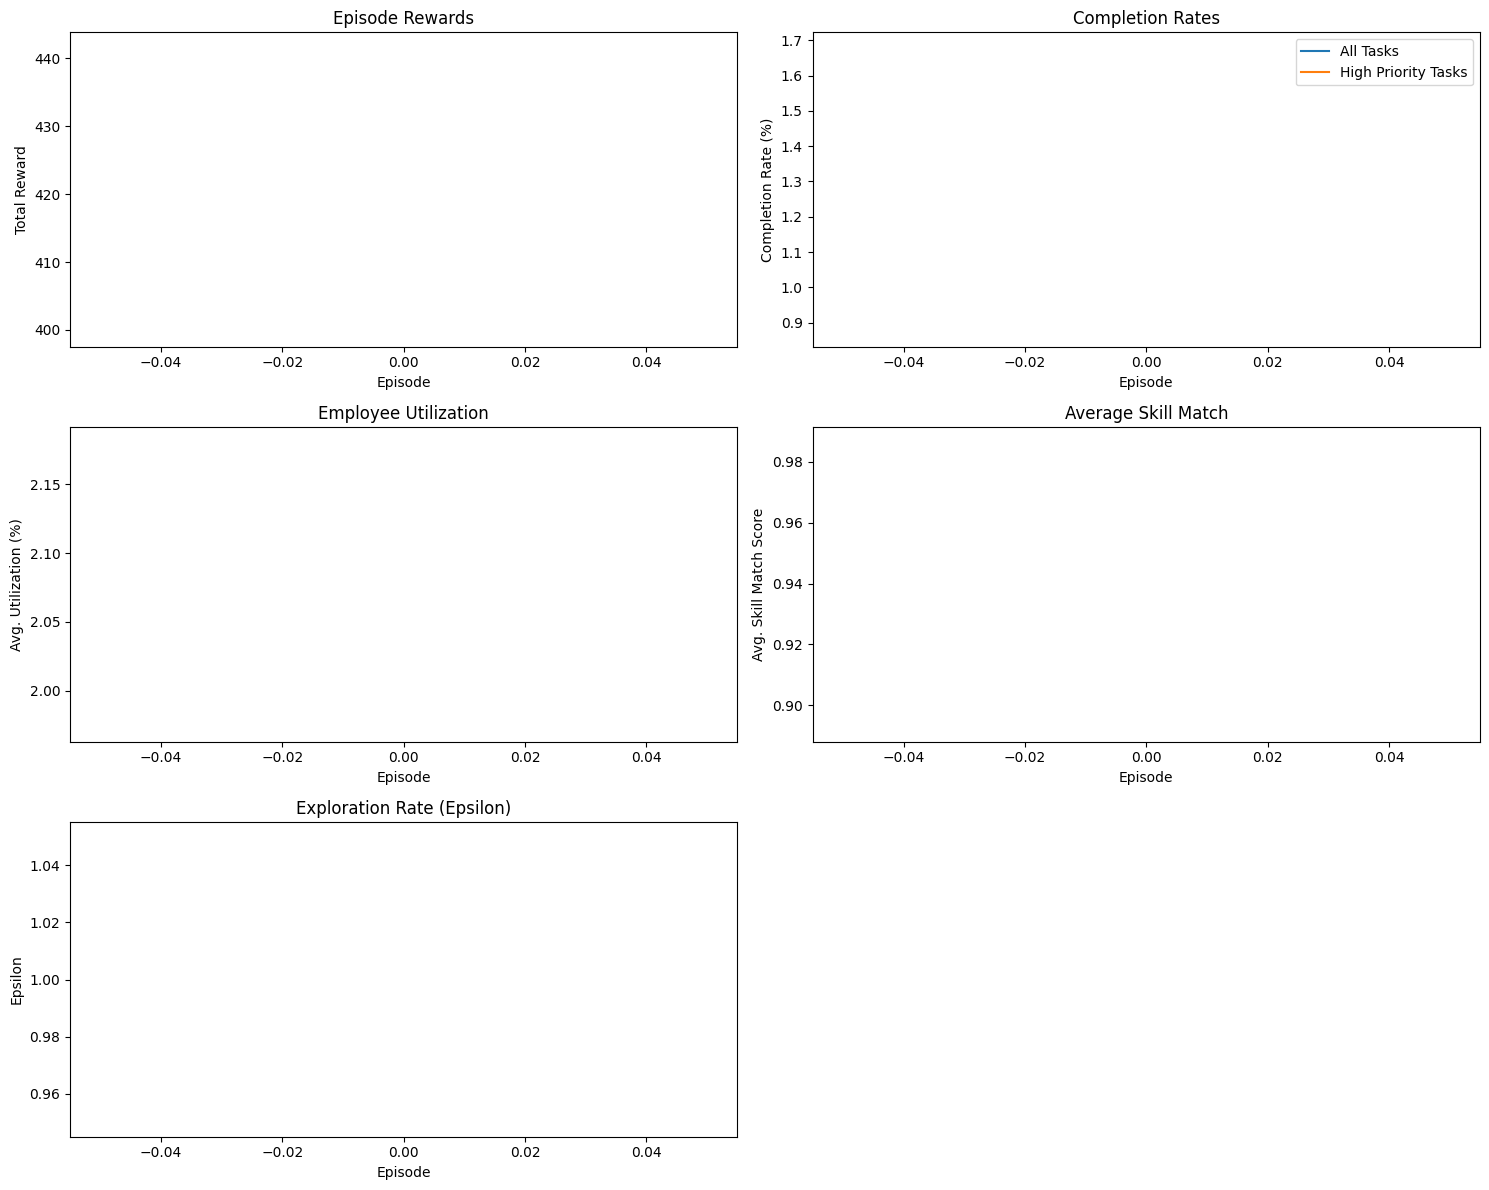

Final Evaluation...
Final evaluation score: 89.74
Training complete!


In [15]:
def main():
    print("Training DQN Task Scheduler Agent...")
    agent = train_scheduler_agent(episodes = 300)
    agent.save_full_model("dqn_scheduler_model.keras")

    print("Final Evaluation...")
    final_score = evaluate_agent(agent)
    print(f"Final evaluation score: {final_score:.2f}")

    print("Training complete!")
    return agent

if __name__ == "__main__":
    agent = main()

This pipeline is designed to automate the process of task allocation. It begins by taking prompts that describe tasks. These prompts are first passed through the NLP module that parses the text to extract important features such as the task type, required skills, priority, duration, deadline, and complexity using spaCy-based matchers and entity rulers.

Once the task is converted into a structured representation, it is passed to a Deep Q-Network (DQN) agent, which uses the extracted information to select the most suitable employee for the task. The agent takes into account factors such as employee skill match, current workload, availability, and fatigue to optimize task distribution across the team.

The system enables end-to-end task assignment from plain-text inputs, making it adaptable, scalable, and intelligent in handling real-world team scheduling problems.

In [16]:
import logging
from typing import List, Dict, Union, Optional

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("task_pipeline")

class TaskPipeline:
    def __init__(self, nlp_module, agent, scheduler):
        """
        Initialize the pipeline with required components.

        Args:
            nlp_module: The NLP module that extracts tasks from prompts
            agent: The agent responsible for assigning tasks to employees
        """
        self.nlp_module = nlp_module
        self.agent = agent
        self.scheduler = scheduler
        logger.info("Task Pipeline initialized")

    def process_prompt(self, prompt: str) -> Dict:
        """
        Process a text prompt through the pipeline.
        Args:
            prompt: The text prompt to be processed
        Returns:
            Dict containing the processing results and status
        """
        try:
            logger.info(f"Processing prompt: {prompt[:50]}...")
            extracted_tasks = self.extract_tasks(prompt)

            if not extracted_tasks:
                return {
                    "status": "warning",
                    "message": "No tasks were extracted from the prompt",
                    "tasks": []
                }
            assignment_results = self.assign_tasks(extracted_tasks)

            return {
                "status": "success",
                "message": f"Successfully processed {len(extracted_tasks)} task(s)",
                "tasks": extracted_tasks,
                "assignments": assignment_results
            }

        except Exception as e:
            logger.error(f"Error processing prompt: {str(e)}")
            return {
                "status": "error",
                "message": f"Failed to process prompt: {str(e)}",
                "tasks": []
            }

    def extract_tasks(self, prompt: str) -> List[Dict]:
        """
        Extract tasks from the prompt using the NLP module.
        Args:
            prompt: The text prompt to extract tasks from
        Returns:
            List of task dictionaries
        """
        logger.info("Extracting tasks from prompt")
        try:
            tasks = self.nlp_module.parse_texts(prompt)
            validated_tasks = []
            for i, task in enumerate(tasks):
                if self._validate_task(task):
                    if "task_id" not in task:
                        task["id"] = f"task_{i+1}"
                    validated_tasks.append(task)
                else:
                    logger.warning(f"Skipping invalid task: {task}")

            logger.info(f"Extracted {len(validated_tasks)} valid tasks")
            return validated_tasks
        except Exception as e:
            logger.error(f"Task extraction failed: {str(e)}")
            raise

    def assign_tasks(self, tasks: List[Dict]) -> List[Dict]:
            """
            Assign tasks to employees using the agent's batch assignment function.

            Args:
                tasks: List of task dictionaries to be assigned

            Returns:
                List of assignment results
            """
            logger.info(f"Assigning {len(tasks)} tasks to employees")
            try:
                employees = self.scheduler.employees
                day_of_week = datetime.datetime.now().weekday()
                assignment_results = self.agent.assign_batch_tasks(
                    tasks,
                    employees,
                    day_of_week
                )
                formatted_results = self._format_assignments_for_response(assignment_results, tasks)
                return formatted_results

            except Exception as e:
                logger.error(f"Task assignment failed: {str(e)}")
                raise
    def _format_assignments_for_response(self, batch_results: Dict, original_tasks: List[Dict]) -> List[Dict]:
        """
        Convert batch assignment results back to pipeline response format.

        Args:
            batch_results: Results from assign_batch_tasks
            original_tasks: Original tasks from pipeline

        Returns:
            List of assignment results in pipeline format
        """
        formatted_results = []
        task_map = {task.get("task_id"): task for task in original_tasks}

        for task_id, assignment in batch_results.items():
            original_task = task_map.get(task_id, {})

            result = {
                "task_id": task_id,
                "status": assignment.get("status"),
                "employee_id": assignment.get("employee_id") if assignment.get("status") == "assigned" else None,
                "employee_name": None,
                "reward": assignment.get("reward", 0)
            }

            if result["employee_id"] is not None:
                employees = self.scheduler.employees
                for emp in employees:
                    if emp.get("id") == result["employee_id"]:
                        result["employee_name"] = emp.get("name")
                        break

            for key, value in assignment.items():
                if key not in ["status", "employee_id", "reward"]:
                    result[key] = value

            formatted_results.append(result)
        return formatted_results

    def _validate_task(self, task: Dict) -> bool:
        """
        Validate that a task has the required fields.
        Args:
            task: Task dictionary to validate
        Returns:
            Boolean indicating if the task is valid
        """
        required_fields = ["task_type", "duration", "deadline", "priority", "complexity"]
        return all(field in task for field in required_fields)


def main(prompt):
    nlp_module = TaskNLP()
    state_size = 31
    action_size = NUM_EMPLOYEES + 1
    agent = DQNSchedulerAgent(state_size, action_size)
    agent.model.load_weights("/content/dqn_scheduler_model.keras")
    scheduler = TaskScheduler()
    pipeline = TaskPipeline(nlp_module, agent, scheduler)

    result = pipeline.process_prompt(prompt)
    print(f"Pipeline result: {result}")

if __name__ == "__main__":
    sample_prompt = [
        "I need someone to do a bug fix with high complexity.",
        "We require a feature development with medium complexity.",
        "Please perform a code review with low priority.",
        "Need to do a bug fix."
    ]
    main(sample_prompt)

Pipeline result: {'status': 'success', 'message': 'Successfully processed 4 task(s)', 'tasks': [{'task_type': {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)}, 'skill_requirements': array([0.6 , 0.6 , 0.12, 0.04, 0.08, 0.12, 0.03, 0.12]), 'priority': 5, 'duration': 1.4527275022085795, 'deadline': 7, 'complexity': 9, 'id': 'task_1'}, {'task_type': {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)}, 'skill_requirements': array([0.8 , 0.01, 0.6 , 0.6 , 0.3 , 0.02, 0.15, 0.04]), 'priority': 5, 'duration': 6.598226364623693, 'deadline': 7, 'complexity': 6, 'id': 'task_2'}, {'task_type': {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)}, 'skill_requirements': array([0.6 , 0.6 , 0.3 , 0.14, 0.6 , 0.14, 0.23, 0.25]), 'priority': 3, 'duration': 2.7858393930967837, 'deadline': 7, 'complexity': 5, 'id': 'task_3'}, {'task_type': {'name':

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Inthis section, the major focus is to buid the streamlit UI for better visualization of the AI scheduler.
Most of the code is copied from the sections above as it is, only the streamlit UI is written. Also, to host the website on internet, we have used an external service by ngrok. Here, I have applied my own authorization key, but you can create your own, by creating an account on ngrok

In [17]:
%%writefile app.py
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
import numpy as np
import random
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import datetime
import pandas as pd
import json
import matplotlib.pyplot as plt
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import logging
from typing import List, Dict

task_types = [
    {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)},
    {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)},
    {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)},
    {'name': 'Documentation', 'skill_focus': [5, 6], 'duration_range': (1, 5), 'complexity_range': (1, 5)},
    {'name': 'Design', 'skill_focus': [2, 7], 'duration_range': (2, 6), 'complexity_range': (3, 7)},
    {'name': 'Testing', 'skill_focus': [1, 4], 'duration_range': (1, 4), 'complexity_range': (2, 6)},
    {'name': 'DevOps', 'skill_focus': [3, 6], 'duration_range': (1, 6), 'complexity_range': (3, 9)},
    {'name': 'Customer support', 'skill_focus': [5, 7], 'duration_range': (1, 3), 'complexity_range': (1, 7)},
]

class TaskNLP:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")
        self.skill_map = {
            0: ["coding", "programming", "debugging", "development"],
            1: ["testing", "qa", "quality assurance", "verification"],
            2: ["design", "ui", "ux", "user experience"],
            3: ["analysis", "analytics", "data processing", "reporting"],
            4: ["review", "code review"],
            5: ["documentation", "writing", "technical writing"],
            6: ["devops", "cloud", "infrastructure"],
            7: ["customer", "user", "support"]
        }
        self._setup_entities()

    # def _calculate_skill_strength(self, skill_term, doc):
    #     skill_value = 0.6
    #     for token in doc:
    #         if token.text.lower() == skill_term.lower():
    #             if token.dep_ == "amod" or token.dep_ == "advmod":
    #                 if token.head.text.lower() in ["strong", "expert", "advanced"]:
    #                     skill_value = 0.9
    #                 elif token.head.text.lower() in ["basic", "beginner"]:
    #                     skill_value = 0.4

    #             for child in token.children:
    #                 if child.dep_ in ["acomp", "xcomp"] and child.pos_ == "VERB":
    #                     if child.text.lower() in ["need", "require", "must"]:
    #                         skill_value = max(skill_value, 0.8)

    #     return skill_value

    def _calculate_skill_strength(self, skill_term, doc):
        skill_value = 0.6

        for token in doc:
            if token.text.lower() == skill_term.lower():
                for child in token.children:
                    if child.dep_ in ["amod", "advmod"]:
                        if child.text.lower() in ["strong", "expert", "advanced"]:
                            skill_value = max(skill_value, 0.9)
                        elif child.text.lower() in ["basic", "beginner"]:
                            skill_value = min(skill_value, 0.4)

                if token.dep_ in ["nsubj", "attr", "dobj"]:
                    for child in token.head.children:
                        if child.dep_ in ["acomp", "amod"]:
                            if child.text.lower() in ["advanced", "strong", "expert"]:
                                skill_value = max(skill_value, 0.9)
                            elif child.text.lower() in ["basic", "beginner"]:
                                skill_value = min(skill_value, 0.4)

                for ancestor in token.ancestors:
                    if ancestor.pos_ == "VERB" and ancestor.lemma_ in ["require", "need", "must", "expect", "prefer"]:
                        skill_value = max(skill_value, 0.8)

        return skill_value


    def _setup_entities(self):
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = []
        for skill_id, terms in self.skill_map.items():
            patterns.extend([self.nlp.make_doc(term) for term in terms])
        self.matcher.add("SKILL", patterns)

        task_patterns = []
        for task_type in task_types:
            task_patterns.append(self.nlp.make_doc(task_type['name'].lower()))
        self.task_matcher = PhraseMatcher(self.nlp.vocab)
        self.task_matcher.add("TASK_TYPE", task_patterns)

        ruler = self.nlp.add_pipe("entity_ruler", before="ner")
        patterns = [
            {"label": "PRIORITY", "pattern": [{"LOWER": {"IN": ["high", "medium", "low"]}}]},

            {"label": "DURATION", "pattern": [{"LIKE_NUM": True}, {"LOWER": {"IN": ["hour", "hours", "hr", "hrs"]}}]},
            {"label": "DURATION", "pattern": [{"LOWER": {"IN": ["around", "about", "approximately"]}}, {"LIKE_NUM": True}, {"LOWER": {"IN": ["hours", "hrs"]}}]},
            {"label": "DURATION", "pattern": [{"LOWER": "duration"}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},

            {"label": "DEADLINE", "pattern": [{"LIKE_NUM": True}, {"LOWER": {"IN": ["day", "days"]}}]},
            {"label": "DEADLINE", "pattern": [{"LOWER": "deadline"}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},

            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["complexity", "difficulty", "level"]}}, {"LIKE_NUM": True}]},
            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["high", "medium", "low"]}}, {"LOWER": {"IN": ["complexity", "difficulty"]}}]},
            {"label": "COMPLEXITY", "pattern": [{"LOWER": {"IN": ["complexity"]}}, {"IS_PUNCT": True, "OP": "?"}, {"LIKE_NUM": True}]},
        ]
        ruler.add_patterns(patterns)

    def _map_skill(self, token_text):
        token_doc = self.nlp(token_text)
        similarities = []
        for skill_id, terms in self.skill_map.items():
            max_sim = max(
                token_doc.similarity(self.nlp(term))
                for term in terms
            )
            similarities.append((skill_id, max_sim))

        return max(similarities, key=lambda x: x[1])[0]

    def parse_text(self, text):
        doc = self.nlp(text.lower())
        result = {
            "task_type": None,
            "skill_requirements": np.zeros(8),
            "priority": 5,
            "duration": None,
            "deadline": None,
            "complexity": 5
        }

        task_matches = self.task_matcher(doc)
        for match_id, start, end in task_matches:
            span = doc[start:end]
            for task_type in task_types:
                if task_type['name'].lower() == span.text.lower():
                    result["task_type"] = task_type
                    break

        for skill_id, terms in self.skill_map.items():
            for term in terms:
                if term in text.lower():
                    strength = self._calculate_skill_strength(term, doc)
                    result["skill_requirements"][skill_id] = max(
                        result["skill_requirements"][skill_id],
                        strength
                    )

        if result["task_type"]:
            for skill in result["task_type"]['skill_focus']:
                if result["skill_requirements"][skill] == 0:
                    result["skill_requirements"][skill] = 0.6

        for i in range(len(result["skill_requirements"])):
            if result["skill_requirements"][i] == 0:
                result["skill_requirements"][i] = round(np.random.uniform(0.0, 0.4),2)

        for ent in doc.ents:
            if ent.label_ == "PRIORITY":
                result["priority"] = {"high": 9, "medium": 6, "low": 3}.get(ent.text.lower(), 5)
            elif ent.label_ == "DURATION":
                result["duration"] = float(ent.text.split()[0])
            elif ent.label_ == "DEADLINE":
                result["deadline"] = int(ent.text.split()[0])
            elif ent.label_ == "COMPLEXITY":
                text = ent.text.lower()
                if "high" in text:
                    result["complexity"] = 9
                elif "medium" in text:
                    result["complexity"] = 6
                elif "low" in text:
                    result["complexity"] = 3
                else:
                    for token in ent:
                        if token.like_num:
                            result["complexity"] = int(token.text)
                            break

        if not result["duration"]:
            if result["task_type"]:
                result["duration"] = np.random.uniform(*result["task_type"]["duration_range"])
            else:
                result["duration"] = 4.0
        if not result["deadline"]:
            result["deadline"] = 7

        return result


    def parse_texts(self, texts):
        results = []
        for text in texts:
            result = self.parse_text(text)
            results.append(result)
        return results

NUM_EMPLOYEES = 10
NUM_SKILLS = 8
MAX_TASKS_PER_DAY = 25
BATCH_SIZE = 64
EPISODES = 1
ACCUMULATION_STEPS = 16
PRIORITY_WEIGHTS = {1: 0.1, 2: 0.2, 3: 0.3, 4: 0.5, 5: 0.7, 6: 1.0, 7: 1.5, 8: 2.0, 9: 3.0, 10: 5.0}

class DQNSchedulerAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        self.predict_fn = self._create_predict_function()
        self.target_predict_fn = self._create_target_predict_function()

        self.task_assignments = {}
        self.training_history = {
            'episode_rewards': [],
            'completion_rates': [],
            'high_priority_rates': [],
            'employee_utilization': [],
            'avg_skill_match': []
        }

    def _build_model(self):
        """Build a neural network for decision making with additional layers for complexity"""
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber_loss', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def _create_predict_function(self):
        """Create optimized prediction function with reduced retracing"""
        @tf.function(reduce_retracing=True)
        def predict_fn(states):
            return self.model(states, training=False)
        return predict_fn

    def _create_target_predict_function(self):
        """Create optimized target prediction function with reduced retracing"""
        @tf.function(reduce_retracing=True)
        def predict_target_fn(states):
            return self.target_model(states, training=False)
        return predict_target_fn

    def update_target_model(self):
        """Copy weights from model to target_model"""
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluation=False):
        """
        Choose action based on current state

        Args:
            state: Current state vector
            evaluation: If True, uses greedy policy (no exploration)
        """
        if not evaluation and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        act_values = self.predict_fn(state_tensor).numpy()
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """Train the model using experience replay with optimized batching and prioritized sampling"""
        if len(self.memory) < batch_size:
            return

        memory_size = len(self.memory)
        recent_size = min(memory_size // 2, 1000)
        recent_sample_count = min(int(batch_size * 0.7), recent_size)

        recent_samples = random.sample(list(self.memory)[-recent_size:], recent_sample_count)
        random_samples = random.sample(list(self.memory), int(batch_size * 0.3))
        minibatch = recent_samples + random_samples

        states = np.vstack([sample[0] for sample in minibatch])
        actions = np.array([sample[1] for sample in minibatch])
        rewards = np.array([sample[2] for sample in minibatch])
        next_states = np.vstack([sample[3] for sample in minibatch])
        dones = np.array([sample[4] for sample in minibatch])

        states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        targets = self.predict_fn(states_tensor).numpy()
        next_targets = self.target_predict_fn(next_states_tensor).numpy()
        next_actions = np.argmax(self.predict_fn(next_states_tensor).numpy(), axis=1)

        for i in range(len(minibatch)):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * next_targets[i, next_actions[i]]

        accumulated_grads = None

        for step in range(0, batch_size, ACCUMULATION_STEPS):
            end_idx = min(step + ACCUMULATION_STEPS, batch_size)
            batch_states = states_tensor[step:end_idx]
            batch_targets = targets[step:end_idx]

            with tf.GradientTape() as tape:
                predictions = self.model(batch_states, training=True)
                error = batch_targets - predictions
                quadratic = tf.minimum(tf.abs(error), 1.0)
                linear = tf.abs(error) - quadratic
                loss = tf.reduce_mean(0.5 * tf.square(quadratic) + linear)

            grads = tape.gradient(loss, self.model.trainable_variables)

            if accumulated_grads is None:
                accumulated_grads = grads
            else:
                accumulated_grads = [accumulated_grad + grad for accumulated_grad, grad in zip(accumulated_grads, grads)]

            if (step + ACCUMULATION_STEPS >= batch_size) or (end_idx == batch_size):
                normalized_grads = [grad / (end_idx - step) for grad in accumulated_grads]
                normalized_grads, _ = tf.clip_by_global_norm(normalized_grads, 5.0)

                self.model.optimizer.apply_gradients(zip(normalized_grads, self.model.trainable_variables))
                accumulated_grads = None

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load model weights"""
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        """Save model weights"""
        self.model.save_weights(name)

    def save_full_model(self, name):
        """Save complete model architecture and weights"""
        self.model.save(name)

    def record_assignment(self, task_id, employee_id=None, metadata=None):
        """Record which employee is assigned to which task with additional metadata"""
        assignment = {"timestamp": datetime.datetime.now().isoformat()}

        if metadata:
            assignment.update(metadata)

        if employee_id is not None:
            assignment["employee_id"] = employee_id
            assignment["status"] = "assigned"
        else:
            assignment["status"] = "rejected"

        self.task_assignments[task_id] = assignment

    def get_assignment_summary(self):
        """Return a summary of task assignments with detailed metrics"""
        assigned_tasks = {task_id: details for task_id, details in self.task_assignments.items()
                         if details.get("status") == "assigned"}

        rejected_tasks = {task_id: details for task_id, details in self.task_assignments.items()
                          if details.get("status") == "rejected"}
        employee_assignments = {}
        for task_id, details in assigned_tasks.items():
            emp_id = details.get("employee_id")
            if emp_id not in employee_assignments:
                employee_assignments[emp_id] = []
            employee_assignments[emp_id].append(task_id)

        workload_distribution = {}
        for emp_id, tasks in employee_assignments.items():
            workload_distribution[emp_id] = len(tasks)

        skill_utilization = {}
        for task_id, details in assigned_tasks.items():
            if "skill_match_score" in details:
                skill_score = details["skill_match_score"]
                if "skill_utilization" not in skill_utilization:
                    skill_utilization["avg_skill_match"] = []
                skill_utilization["avg_skill_match"].append(skill_score)

        if "avg_skill_match" in skill_utilization:
            skill_utilization["avg_skill_match"] = sum(skill_utilization["avg_skill_match"]) / len(skill_utilization["avg_skill_match"])

        return {
            "employee_assignments": employee_assignments,
            "assigned_tasks": assigned_tasks,
            "rejected_tasks": rejected_tasks,
            "workload_distribution": workload_distribution,
            "skill_utilization": skill_utilization
        }

    def assign_batch_tasks(self, tasks, employees, day_of_week):
        """
        Assign multiple tasks in batch mode

        Args:
            tasks: List of tasks to be assigned
            employees: List of employee dictionaries
            day_of_week: Current day of week (0-6)

        Returns:
            dict: Assignment results for each task
        """
        results = {}

        employees_copy = [employee.copy() for employee in employees]
        for employee in employees_copy:
            employee['assigned_tasks'] = []

        for task in tasks:
            employee_id, reward, metadata = self._get_best_employee_for_task(task, employees_copy, day_of_week)

            if employee_id is not None:
                employees_copy[employee_id]['current_workload'] += task['duration']
                employees_copy[employee_id]['current_fatigue'] += task['complexity'] * employees_copy[employee_id]['fatigue_factor']
                employees_copy[employee_id]['assigned_tasks'].append(task['id'])

                results[task['id']] = {
                    "status": "assigned",
                    "employee_id": employee_id,
                    "reward": reward,
                    **metadata
                }
                self.record_assignment(task['id'], employee_id, metadata)
            else:
                results[task['id']] = {
                    "status": "rejected",
                    "reason": "No suitable employee available or rejected by model",
                    "reward": reward,
                    **metadata
                }

                self.record_assignment(task['id'], None, {**metadata, "reason": "No suitable employee or rejected"})

        return results

    def assign_single_task(self, task, employees, day_of_week):
        """
        Determine the best employee for a single task

        Parameters:
        task (dict): Task to be assigned
        employees (list): List of employee dictionaries
        day_of_week (int): Current day of week (0-6)

        Returns:
        tuple: (assigned_employee_id, reward, metadata) or (None, rejection_reward, metadata) if rejected
        """
        return self._get_best_employee_for_task(task, employees, day_of_week)

    def _get_best_employee_for_task(self, task, employees, day_of_week):
        """
        Helper function to find the best employee for a task

        Returns:
        tuple: (best_employee_id, reward, metadata) or (None, rejection_reward, metadata)
        """
        best_action = None
        best_score = float('-inf')
        best_employee_idx = None

        employee_states = []
        employee_idxs = []

        for employee_idx, employee in enumerate(employees):
            if employee['availability'][day_of_week] <= employee['current_workload']:
                continue

            if employee['current_fatigue'] > employee.get('fatigue_threshold', 8.0):
                continue

            state = create_state_vector(employee, task, day_of_week)
            state = np.reshape(state, [1, self.state_size])

            employee_states.append(state)
            employee_idxs.append(employee_idx)

        if not employee_states:
            deadline_urgency = calculate_deadline_urgency(task['deadline'])
            rejection_reward = -1 * PRIORITY_WEIGHTS.get(task['priority'], 1.0) * deadline_urgency

            metadata = {
                "task_id": task['id'],
                "task_priority": task['priority'],
                "task_deadline": task['deadline'],
                "deadline_urgency": deadline_urgency,
                "reason": "No available employees"
            }

            return None, rejection_reward, metadata

        states_tensor = tf.convert_to_tensor(np.vstack(employee_states), dtype=tf.float32)
        predictions = self.predict_fn(states_tensor).numpy()

        for i, emp_idx in enumerate(employee_idxs):
            for action in range(self.action_size):
                if predictions[i, action] > best_score:
                    best_score = predictions[i, action]
                    best_action = action
                    best_employee_idx = emp_idx

        employee = employees[best_employee_idx]
        skill_match = calculate_skill_match(employee['skills'], task['skill_requirements'])

        metadata = {
            "task_id": task['id'],
            "task_priority": task['priority'],
            "task_deadline": task['deadline'],
            "skill_match_score": skill_match,
            "expected_quality": calculate_expected_quality(skill_match, employee['current_fatigue']),
            "action_q_value": best_score
        }

        if best_action < NUM_EMPLOYEES:
            reward = calculate_reward(employee, task, 'assign', skill_match)
            metadata["action"] = "assign"
            return best_employee_idx, reward, metadata
        else:
            reward = calculate_reward(employee, task, 'reject', skill_match)
            metadata["action"] = "reject"
            return None, reward, metadata

    def track_training_metrics(self, episode, total_reward, completion_rate, high_priority_rate,
                              employee_utilization, avg_skill_match):
        """Track metrics during training for visualization later"""
        self.training_history['episode_rewards'].append(total_reward)
        self.training_history['completion_rates'].append(completion_rate)
        self.training_history['high_priority_rates'].append(high_priority_rate)
        self.training_history['employee_utilization'].append(employee_utilization)
        self.training_history['avg_skill_match'].append(avg_skill_match)

    def save_training_history(self, filename):
        """Save training metrics to a file"""
        with open(filename, 'w') as f:
            json.dump(self.training_history, f)

    def plot_training_metrics(self, save_path=None):
        """Plot training metrics"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))

        axes[0, 0].plot(self.training_history['episode_rewards'])
        axes[0, 0].set_title('Episode Rewards')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Total Reward')

        axes[0, 1].plot(self.training_history['completion_rates'], label='All Tasks')
        axes[0, 1].plot(self.training_history['high_priority_rates'], label='High Priority Tasks')
        axes[0, 1].set_title('Completion Rates')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Completion Rate (%)')
        axes[0, 1].legend()

        axes[1, 0].plot(self.training_history['employee_utilization'])
        axes[1, 0].set_title('Employee Utilization')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Avg. Utilization (%)')

        axes[1, 1].plot(self.training_history['avg_skill_match'])
        axes[1, 1].set_title('Average Skill Match')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Avg. Skill Match Score')

        episodes = range(len(self.training_history['episode_rewards']))
        epsilon_values = [1.0 * (self.epsilon_decay ** episode) for episode in episodes]
        epsilon_values = [max(e, self.epsilon_min) for e in epsilon_values]

        axes[2, 0].plot(epsilon_values)
        axes[2, 0].set_title('Exploration Rate (Epsilon)')
        axes[2, 0].set_xlabel('Episode')
        axes[2, 0].set_ylabel('Epsilon')

        axes[2, 1].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

class TaskScheduler:
    """Realistic task scheduler environment"""
    def __init__(self):
        """Initialize the task scheduler with employees and tasks"""
        self.employees = self._generate_employees()
        self.tasks = self._generate_tasks(100)
        self.day = 0
        self.calendar = {}
        self.performance_metrics = {
            'completed_tasks': 0,
            'rejected_tasks': 0,
            'overdue_tasks': 0,
            'avg_completion_time': [],
            'employee_utilization': {}
        }

    def _generate_employees(self):
        """Generate realistic employees with varying skills and attributes"""
        employees = []
        availability_patterns = [
            [8, 8, 8, 8, 8, 0, 0],
            [8, 8, 8, 8, 8, 4, 0],
            [0, 8, 8, 8, 8, 8, 0],
            [8, 8, 8, 8, 0, 0, 0],
            [6, 6, 6, 6, 6, 0, 0],
            [10, 10, 10, 10, 0, 0, 0],
            [8, 8, 0, 8, 8, 8, 0],
            [6, 6, 6, 6, 6, 6, 0],
        ]

        for i in range(NUM_EMPLOYEES):
            pattern_weights = [0.4, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]
            pattern_idx = np.random.choice(len(availability_patterns), p=pattern_weights)

            is_specialist = np.random.random() < 0.6

            skills = np.zeros(NUM_SKILLS)
            if is_specialist:
                num_specialties = np.random.randint(1, 4)
                specialty_skills = np.random.choice(NUM_SKILLS, num_specialties, replace=False)

                for skill in specialty_skills:
                    skills[skill] = np.random.uniform(0.7, 1.0)

                for skill in range(NUM_SKILLS):
                    if skill not in specialty_skills:
                        skills[skill] = np.random.uniform(0.1, 0.5)
            else:
                for skill in range(NUM_SKILLS):
                    skills[skill] = np.random.uniform(0.4, 0.8)

            is_senior = np.random.random() < 0.3
            if is_senior:
                skills = np.minimum(skills * 1.3, 1.0)

            fatigue_factor = np.random.uniform(0.8, 1.2)
            fatigue_threshold = 10.0 if is_senior else 8.0

            employees.append({
                'id': i,
                'skills': skills,
                'availability': availability_patterns[pattern_idx],
                'current_workload': 0,
                'current_fatigue': 0,
                'fatigue_factor': fatigue_factor,
                'fatigue_threshold': fatigue_threshold,
                'is_senior': is_senior,
                'completed_tasks': 0,
                'total_work_hours': 0
            })

        return employees

    def _generate_tasks(self, num_tasks):
        """Generate a realistic set of tasks with varying attributes"""
        tasks = []
        task_types = [
            {'name': 'Bug fix', 'skill_focus': [0, 1], 'duration_range': (1, 4), 'complexity_range': (1, 8)},
            {'name': 'Feature development', 'skill_focus': [0, 2, 3], 'duration_range': (2, 8), 'complexity_range': (3, 8)},
            {'name': 'Code review', 'skill_focus': [0, 1, 4], 'duration_range': (1, 3), 'complexity_range': (2, 6)},
            {'name': 'Documentation', 'skill_focus': [5, 6], 'duration_range': (1, 5), 'complexity_range': (1, 5)},
            {'name': 'Design', 'skill_focus': [2, 7], 'duration_range': (2, 6), 'complexity_range': (3, 7)},
            {'name': 'Testing', 'skill_focus': [1, 4], 'duration_range': (1, 4), 'complexity_range': (2, 6)},
            {'name': 'DevOps', 'skill_focus': [3, 6], 'duration_range': (1, 6), 'complexity_range': (3, 9)},
            {'name': 'Customer support', 'skill_focus': [5, 7], 'duration_range': (1, 3), 'complexity_range': (1, 7)},
        ]

        for i in range(num_tasks):
            task_type = random.choice(task_types)
            skill_requirements = np.zeros(NUM_SKILLS)

            for skill in task_type['skill_focus']:
                skill_requirements[skill] = np.random.uniform(0.6, 1.0)

            for skill in range(NUM_SKILLS):
                if skill not in task_type['skill_focus']:
                    if np.random.random() < 0.3:
                        skill_requirements[skill] = np.random.uniform(0.1, 0.5)

            duration = np.random.randint(*task_type['duration_range'])

            complexity = np.random.randint(*task_type['complexity_range']) / 10.0
            priority_roll = np.random.random()
            if priority_roll < 0.1:
                priority = np.random.randint(8, 11)
            elif priority_roll < 0.4:
                priority = np.random.randint(5, 8)
            else:
                priority = np.random.randint(1, 5)

            deadline_base = max(1, 10 - priority)
            deadline_variation = np.random.randint(0, 5)
            deadline = deadline_base + deadline_variation

            tasks.append({
                'id': i,
                'type': task_type['name'],
                'skill_requirements': skill_requirements,
                'duration': duration,
                'complexity': complexity,
                'priority': priority,
                'deadline': deadline,
                'status': 'pending',
                'assigned_to': None,
                'created_day': 0,
                'completed_day': None
            })

        return tasks

    def generate_daily_tasks(self, day, base_count=10, variation=5):
        """Generate new tasks for a given day with realistic distribution"""
        day_of_week = day % 7

        if day_of_week == 5:
            task_multiplier = 0.5
        elif day_of_week == 6:
            task_multiplier = 0.3
        else:
            if day_of_week == 0:
                task_multiplier = 1.3
            elif day_of_week == 1:
                task_multiplier = 1.2
            else:
                task_multiplier = 1.0

        num_new_tasks = int(base_count * task_multiplier + random.randint(-variation, variation))
        num_new_tasks = max(1, num_new_tasks)

        current_task_id = len(self.tasks)
        new_tasks = []

        for i in range(num_new_tasks):
            task = self._generate_tasks(1)[0]
            task['id'] = current_task_id + i
            task['created_day'] = day
            new_tasks.append(task)

        self.tasks.extend(new_tasks)
        return new_tasks

    def step_day(self):
        """Advance the simulation by one day"""
        self.day += 1
        day_of_week = self.day % 7
        new_tasks = self.generate_daily_tasks(self.day)

        for task in self.tasks:
            if task['status'] == 'assigned':
                employee = self.employees[task['assigned_to']]

                if task['assigned_day'] < self.day:
                    task['status'] = 'completed'
                    task['completed_day'] = self.day
                    self.performance_metrics['completed_tasks'] += 1
                    employee['completed_tasks'] += 1

        for task in self.tasks:
            if task['status'] == 'pending' and task['deadline'] < self.day:
                task['status'] = 'overdue'
                self.performance_metrics['overdue_tasks'] += 1

        for employee in self.employees:
            employee['current_workload'] = 0
            employee['current_fatigue'] *= 0.7

        return day_of_week, new_tasks

def calculate_skill_match(employee_skills, task_skill_requirements):
    """
    Calculate how well an employee's skills match the task requirements

    Returns:
    float: 0.0-1.0 skill match score where 1.0 is perfect match
    """
    if sum(task_skill_requirements) == 0:
        return 1.0

    match_score = 0.0
    requirement_sum = sum(task_skill_requirements)

    for i in range(len(employee_skills)):
        if task_skill_requirements[i] > 0:
            weight = task_skill_requirements[i] / requirement_sum
            coverage = min(employee_skills[i] / task_skill_requirements[i], 1.0)
            match_score += weight * coverage

    return match_score

def calculate_expected_quality(skill_match, employee_fatigue):
    """Calculate expected quality of work based on skill match and fatigue"""
    quality = skill_match * (1.0 - (employee_fatigue / 10.0))
    return max(0.3, min(quality, 1.0))

def calculate_deadline_urgency(deadline):
    """Calculate urgency factor based on task deadline"""
    if deadline <= 1:
        return 2.0
    elif deadline <= 3:
        return 1.5
    elif deadline <= 5:
        return 1.2
    else:
        return 1.0

def calculate_reward(employee, task, action, skill_match):
    """
    Calculate reward for a given task assignment or rejection

    Parameters:
    employee (dict): Employee details
    task (dict): Task details
    action (str): Either 'assign' or 'reject'
    skill_match (float): Skill match score

    Returns:
    float: Calculated reward
    """
    priority_weight = PRIORITY_WEIGHTS.get(task['priority'], 1.0)
    deadline_urgency = calculate_deadline_urgency(task['deadline'])

    if action == 'assign':
        base_reward = 1.0
        priority_factor = priority_weight * deadline_urgency
        skill_factor = skill_match
        fatigue_penalty = min(1.0, employee['current_fatigue'] / employee['fatigue_threshold']) * 0.5
        reward = base_reward * priority_factor * skill_factor * (1.0 - fatigue_penalty)
        return reward

    else:
        rejection_penalty = -0.5 * priority_weight * deadline_urgency
        if skill_match < 0.3:
            rejection_penalty *= (skill_match / 0.3)
        if employee['current_fatigue'] > employee['fatigue_threshold'] * 0.8:
            fatigue_factor = min(1.0, employee['current_fatigue'] / employee['fatigue_threshold'])
            rejection_penalty *= (1.0 - fatigue_factor * 0.5)
        return rejection_penalty

def create_state_vector(employee, task, day_of_week):
    """
    Create a state vector that represents the current state for decision making

    Parameters:
    employee (dict): Employee details
    task (dict): Task details
    day_of_week (int): Current day of week (0-6)

    Returns:
    numpy.array: State vector
    """
    state = []
    state.append(employee['current_workload'] / 8.0)
    state.append(employee['current_fatigue'] / 10.0)
    state.append(employee['availability'][day_of_week] / 10.0)
    state.append(1.0 if employee['is_senior'] else 0.0)

    for skill in employee['skills']:
        state.append(skill)

    state.append(task['duration'] / 8.0)
    state.append(task['complexity'])
    state.append(task['priority'] / 10.0)
    state.append(min(1.0, 5.0 / task['deadline']))

    for skill_req in task['skill_requirements']:
        state.append(skill_req)
    for d in range(7):
        state.append(1.0 if d == day_of_week else 0.0)

    return np.array(state)

import logging
from typing import List, Dict, Union, Optional

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("task_pipeline")

class TaskPipeline:
    def __init__(self, nlp_module, agent, scheduler):
        """
        Initialize the pipeline with required components.

        Args:
            nlp_module: The NLP module that extracts tasks from prompts
            agent: The agent responsible for assigning tasks to employees
        """
        self.nlp_module = nlp_module
        self.agent = agent
        self.scheduler = scheduler
        logger.info("Task Pipeline initialized")

    def process_prompt(self, prompt: str) -> Dict:
        """
        Process a text prompt through the pipeline.
        Args:
            prompt: The text prompt to be processed
        Returns:
            Dict containing the processing results and status
        """
        try:
            logger.info(f"Processing prompt: {prompt[:50]}...")
            extracted_tasks = self.extract_tasks(prompt)

            if not extracted_tasks:
                return {
                    "status": "warning",
                    "message": "No tasks were extracted from the prompt",
                    "tasks": []
                }
            assignment_results = self.assign_tasks(extracted_tasks)

            return {
                "status": "success",
                "message": f"Successfully processed {len(extracted_tasks)} task(s)",
                "tasks": extracted_tasks,
                "assignments": assignment_results
            }

        except Exception as e:
            logger.error(f"Error processing prompt: {str(e)}")
            return {
                "status": "error",
                "message": f"Failed to process prompt: {str(e)}",
                "tasks": []
            }

    def extract_tasks(self, prompt: str) -> List[Dict]:
        """
        Extract tasks from the prompt using the NLP module.
        Args:
            prompt: The text prompt to extract tasks from
        Returns:
            List of task dictionaries
        """
        logger.info("Extracting tasks from prompt")
        try:
            tasks = self.nlp_module.parse_texts(prompt)
            validated_tasks = []
            for i, task in enumerate(tasks):
                if self._validate_task(task):
                    if "task_id" not in task:
                        task["id"] = f"task_{i+1}"
                    validated_tasks.append(task)
                else:
                    logger.warning(f"Skipping invalid task: {task}")

            logger.info(f"Extracted {len(validated_tasks)} valid tasks")
            return validated_tasks
        except Exception as e:
            logger.error(f"Task extraction failed: {str(e)}")
            raise

    def assign_tasks(self, tasks: List[Dict]) -> List[Dict]:
            """
            Assign tasks to employees using the agent's batch assignment function.

            Args:
                tasks: List of task dictionaries to be assigned

            Returns:
                List of assignment results
            """
            logger.info(f"Assigning {len(tasks)} tasks to employees")
            try:
                employees = self.scheduler.employees
                day_of_week = datetime.datetime.now().weekday()
                assignment_results = self.agent.assign_batch_tasks(
                    tasks,
                    employees,
                    day_of_week
                )
                formatted_results = self._format_assignments_for_response(assignment_results, tasks)
                return formatted_results

            except Exception as e:
                logger.error(f"Task assignment failed: {str(e)}")
                raise
    def _format_assignments_for_response(self, batch_results: Dict, original_tasks: List[Dict]) -> List[Dict]:
        """
        Convert batch assignment results back to pipeline response format.

        Args:
            batch_results: Results from assign_batch_tasks
            original_tasks: Original tasks from pipeline

        Returns:
            List of assignment results in pipeline format
        """
        formatted_results = []
        task_map = {task.get("task_id"): task for task in original_tasks}

        for task_id, assignment in batch_results.items():
            original_task = task_map.get(task_id, {})

            result = {
                "task_id": task_id,
                "status": assignment.get("status"),
                "employee_id": assignment.get("employee_id") if assignment.get("status") == "assigned" else None,
                "employee_name": None,
                "reward": assignment.get("reward", 0)
            }

            if result["employee_id"] is not None:
                employees = self.scheduler.employees
                for emp in employees:
                    if emp.get("id") == result["employee_id"]:
                        result["employee_name"] = emp.get("name")
                        break

            for key, value in assignment.items():
                if key not in ["status", "employee_id", "reward"]:
                    result[key] = value

            formatted_results.append(result)
        return formatted_results

    def _validate_task(self, task: Dict) -> bool:
        """
        Validate that a task has the required fields.
        Args:
            task: Task dictionary to validate
        Returns:
            Boolean indicating if the task is valid
        """
        required_fields = ["task_type", "duration", "deadline", "priority", "complexity"]
        return all(field in task for field in required_fields)


import streamlit as st
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import random
import datetime


st.set_page_config(
    page_title="AI Task Scheduler",
    page_icon="📋",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Add some CSS styling
st.markdown("""
<style>
    .task-card {
        background-color: #f8f9fa;
        border-left: 4px solid #ffc107;
        padding: 12px;
        margin-bottom: 10px;
        border-radius: 4px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        color: black;
    }

    .employee-card {
        background-color: #f0f7ff;
        border-left: 4px solid #0d6efd;
        padding: 15px;
        margin-bottom: 15px;
        border-radius: 4px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        color: black;
    }

    .assigned-card {
        background-color: #e8f4ea;
        border-left: 4px solid #28a745;
        padding: 12px;
        margin-bottom: 10px;
        border-radius: 4px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }

    .rejected-card {
        background-color: #f9e9eb;
        border-left: 4px solid #dc3545;
        padding: 12px;
        margin-bottom: 10px;
        border-radius: 4px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }

    .status-chip {
        background-color: #ffc107;
        color: #212529;
        font-size: 0.8em;
        padding: 3px 8px;
        border-radius: 12px;
        font-weight: bold;
    }

    .status-chip.assigned {
        background-color: #28a745;
        color: white;
    }

    .status-chip.rejected {
        background-color: #dc3545;
        color: white;
    }

    .skill-bar-container {
        width: 100%;
        background-color: #e9ecef;
        border-radius: 4px;
        margin-bottom: 8px;
    }

    .skill-bar {
        height: 18px;
        border-radius: 4px;
        text-align: right;
        padding-right: 6px;
        font-size: 0.7em;
        font-weight: bold;
        line-height: 18px;
        color: white;
    }

    .employee-skill {
        background-color: #0d6efd;
    }

    .task-skill {
        background-color: #20c997;
    }

    .main-header {
        font-size: 30px;
        font-weight: bold;
        margin-bottom: 10px;
    }

    .sub-header {
        font-size: 22px;
        font-weight: bold;
        margin: 15px 0;
        padding-bottom: 5px;
        border-bottom: 1px solid #dee2e6;
    }
</style>
""", unsafe_allow_html=True)

if 'tasks' not in st.session_state:
    st.session_state.tasks = []

if 'task_history' not in st.session_state:
    st.session_state.task_history = []

if 'assignments' not in st.session_state:
    st.session_state.assignments = []

if 'employees' not in st.session_state:
    st.session_state.employees = []

if 'task_id_counter' not in st.session_state:
    st.session_state.task_id_counter = 1

if 'system_initialized' not in st.session_state:
    st.session_state.system_initialized = False


def initialize_system():
    with st.spinner("Initializing the AI Task Scheduler..."):
        nlp_module = TaskNLP()
        scheduler = TaskScheduler()
        state_size = 31
        action_size = NUM_EMPLOYEES + 1
        agent = DQNSchedulerAgent(state_size, action_size)
        agent.model.load_weights("/content/dqn_scheduler_model.keras")
        pipeline = TaskPipeline(nlp_module, agent, scheduler)

        st.session_state.nlp_module = nlp_module
        st.session_state.scheduler = scheduler
        st.session_state.agent = agent
        st.session_state.pipeline = pipeline
        st.session_state.employees = scheduler.employees
        st.session_state.system_initialized = True

        st.success("System initialized successfully!")
        time.sleep(1)

st.markdown('<div class="main-header">📋 AI Task Scheduler</div>', unsafe_allow_html=True)
st.markdown("#### Powered by NLP and Reinforcement Learning")

with st.sidebar:
    st.markdown("### About the Scheduler")
    st.write("""
    This AI-powered task scheduler uses Natural Language Processing to understand
    task requirements and Deep Reinforcement Learning to optimally assign tasks to employees
    based on skills, workload, and other factors.
    """)

    st.markdown("### How to Use")
    st.write("""
    1. Enter task descriptions in natural language
    2. Add as many tasks as needed
    3. Click 'Assign Tasks' to run the AI assignment algorithm
    4. View results and analytics on task assignments
    """)

    st.markdown("### Tech Stack")
    st.markdown("""
    - NLP: SpaCy for task extraction
    - ML: Tensorflow for Deep Q-Network
    - Data: Pandas & NumPy
    - Visualization: Plotly & Matplotlib
    - UI: Streamlit
    """)

    if not st.session_state.system_initialized:
        if st.button("Initialize System", key="init_button"):
            initialize_system()
    else:
        st.success("System initialized!")

if not st.session_state.system_initialized:
    st.info("Please initialize the system using the button in the sidebar.")
else:
    tab1, tab2, tab3 = st.tabs(["Task Management", "Analytics", "Employees"])

    with tab1:
        col1, col2 = st.columns([2, 1])

        with col1:
            st.markdown('<div class="sub-header">Add New Task</div>', unsafe_allow_html=True)

            task_description = st.text_area(
                "Enter task description in natural language:",
                height=100,
                placeholder="Example: Create a high priority bug fix for the login system. This requires strong programming skills and should take about 3 hours to complete. Deadline is in 2 days."
            )

            col1a, col1b, col1c = st.columns(3)
            with col1a:
                if st.button("Add Task", key="add_task"):
                    if task_description:
                        try:
                            task_results = st.session_state.nlp_module.parse_text(task_description)

                            if task_results["task_type"]:
                                task = {
                                    "id": f"task_{st.session_state.task_id_counter}",
                                    "description": task_description,
                                    "type": task_results["task_type"]["name"],
                                    "skill_requirements": task_results["skill_requirements"].tolist(),
                                    "duration": task_results["duration"],
                                    "complexity": task_results["complexity"],
                                    "priority": task_results["priority"],
                                    "deadline": task_results["deadline"],
                                    "status": "pending",
                                    "assigned_to": None,
                                    "created_day": datetime.datetime.now().day
                                }

                                st.session_state.tasks.append(task)
                                st.session_state.task_history.append(task)
                                st.session_state.task_id_counter += 1
                                st.success(f"Task added: {task['type']}")
                            else:
                                st.error("Could not determine task type. Please provide more specific information.")
                        except Exception as e:
                            st.error(f"Error processing task: {str(e)}")
                    else:
                        st.warning("Please enter a task description")

            with col1b:
                if st.button("Add Sample Tasks", key="add_samples"):
                    sample_tasks = [
                        "Fix the critical login bug that's affecting all users. This requires deep debugging skills and should be done in the next 2 days. Complexity is high.",
                        "Write documentation for the new API features we released last week. Deadline is 5 days from now.",
                        "Design a new user onboarding flow with improved UX. This is a medium priority task with a 4-day deadline.",
                        "Implement the new payment processing system. This is high priority and has a complexity of 8/10. Should be done within a week.",
                        "Review code for the recent frontend changes. This is a low priority task that should take about 2 hours."
                    ]

                    for sample in sample_tasks:
                        task_results = st.session_state.nlp_module.parse_text(sample)

                        if task_results["task_type"]:
                            task = {
                                "id": f"task_{st.session_state.task_id_counter}",
                                "description": sample,
                                "type": task_results["task_type"]["name"],
                                "skill_requirements": task_results["skill_requirements"].tolist(),
                                "duration": task_results["duration"],
                                "complexity": task_results["complexity"],
                                "priority": task_results["priority"],
                                "deadline": task_results["deadline"],
                                "status": "pending",
                                "assigned_to": None,
                                "created_day": datetime.datetime.now().day
                            }

                            st.session_state.tasks.append(task)
                            st.session_state.task_history.append(task)
                            st.session_state.task_id_counter += 1

                    st.success(f"Added {len(sample_tasks)} sample tasks!")

            with col1c:
                if st.button("Assign Tasks", key="assign_tasks"):
                    if st.session_state.tasks:
                        with st.spinner("AI is assigning tasks to the best employees..."):
                            day_of_week = datetime.datetime.now().weekday()

                            pending_tasks = [task for task in st.session_state.tasks if task["status"] == "pending"]

                            if pending_tasks:
                                results = st.session_state.agent.assign_batch_tasks(
                                    pending_tasks,
                                    st.session_state.employees,
                                    day_of_week
                                )

                                for task in st.session_state.tasks:
                                    if task["id"] in results:
                                        result = results[task["id"]]
                                        if result["status"] == "assigned":
                                            task["status"] = "assigned"
                                            task["assigned_to"] = result["employee_id"]
                                            task["assigned_day"] = datetime.datetime.now().day
                                            task["skill_match_score"] = result.get("skill_match_score", 0)
                                            task["expected_quality"] = result.get("expected_quality", 0)
                                        else:
                                            task["status"] = "rejected"
                                            task["reject_reason"] = result.get("reason", "No suitable employee")

                                st.session_state.assignments = results
                                st.success(f"Successfully assigned {sum(1 for r in results.values() if r['status'] == 'assigned')} out of {len(pending_tasks)} tasks!")
                            else:
                                st.warning("No pending tasks to assign")
                    else:
                        st.warning("No tasks available to assign")

        with col2:
            st.markdown('<div class="sub-header">Task Queue</div>', unsafe_allow_html=True)

            if not st.session_state.tasks:
                st.info("No tasks in the queue. Add tasks using the form on the left.")
            else:
                for task in st.session_state.tasks:
                    if task["status"] == "pending":
                        with st.container():
                            st.markdown(f"""
                            <div class="task-card">
                                <strong>{task["type"]}</strong> <span class="status-chip">Pending</span>
                            </div>
                            """, unsafe_allow_html=True)
        if st.session_state.assignments:
            st.markdown('<div class="sub-header">Assignment Results</div>', unsafe_allow_html=True)

            assigned_count = 0
            rejected_count = 0

            col_assigned, col_rejected = st.columns(2)

            with col_assigned:
                st.markdown("### Assigned Tasks")
                assigned_tasks = [task for task in st.session_state.tasks if task["status"] == "assigned"]

                if assigned_tasks:
                    for task in assigned_tasks:
                        employee = next((emp for emp in st.session_state.employees if emp["id"] == task["assigned_to"]), None)

                        if employee:
                            with st.container():
                                st.markdown(f"""
                                <div class="card assigned-card">
                                    <strong>{task["type"]}</strong>
                                    <span class="status-chip assigned">Assigned</span><br>
                                    Assigned to: Employee #{employee["id"]}<br>
                                    Skill Match: {task.get("skill_match_score", 0):.2f}<br>
                                    Expected Quality: {task.get("expected_quality", 0):.2f}<br>
                                </div>
                                """, unsafe_allow_html=True)

                                st.markdown("#### Skill Match Analysis")

                                skill_col1, skill_col2 = st.columns(2)

                                with skill_col1:
                                    st.markdown("**Employee Skills**")
                                    skills = employee["skills"]

                                    for i, skill_val in enumerate(skills):
                                        skill_name = ["Coding", "Testing", "Design", "Analysis", "Review", "Documentation", "DevOps", "Customer Support"][i]
                                        percentage = int(skill_val * 100)

                                        st.markdown(f"""
                                        <div>{skill_name}</div>
                                        <div class="skill-bar-container">
                                            <div class="skill-bar employee-skill" style="width:{percentage}%">{percentage}%</div>
                                        </div>
                                        """, unsafe_allow_html=True)

                                with skill_col2:
                                    st.markdown("**Task Requirements**")
                                    requirements = task["skill_requirements"]

                                    for i, req_val in enumerate(requirements):
                                        skill_name = ["Coding", "Testing", "Design", "Analysis", "Review", "Documentation", "DevOps", "Customer Support"][i]
                                        percentage = int(req_val * 100)

                                        if percentage > 0:
                                            st.markdown(f"""
                                            <div>{skill_name}</div>
                                            <div class="skill-bar-container">
                                                <div class="skill-bar task-skill" style="width:{percentage}%">{percentage}%</div>
                                            </div>
                                            """, unsafe_allow_html=True)

                                st.markdown("---")
                                assigned_count += 1
                else:
                    st.info("No tasks have been assigned yet")

            with col_rejected:
                st.markdown("### Rejected Tasks")
                rejected_tasks = [task for task in st.session_state.tasks if task["status"] == "rejected"]

                if rejected_tasks:
                    for task in rejected_tasks:
                        with st.container():
                            st.markdown(f"""
                            <div class="card rejected-card">
                                <strong>{task["type"]}</strong>
                                <span class="status-chip rejected">Rejected</span><br>
                                Reason: {task.get("reject_reason", "No suitable employee available")}<br>
                                Priority: {task["priority"]}/10<br>
                                Deadline: {task["deadline"]} days<br>
                            </div>
                            """, unsafe_allow_html=True)
                            rejected_count += 1
                else:
                    st.info("No tasks have been rejected")

    with tab2:
        st.markdown('<div class="sub-header">Task Analytics</div>', unsafe_allow_html=True)

        if len(st.session_state.task_history) > 0:
            col_charts1, col_charts2 = st.columns(2)

            with col_charts1:
                task_types = [task["type"] for task in st.session_state.task_history]
                type_counts = {t: task_types.count(t) for t in set(task_types)}

                fig1 = px.pie(
                    values=list(type_counts.values()),
                    names=list(type_counts.keys()),
                    title="Task Distribution by Type",
                    color_discrete_sequence=px.colors.qualitative.Pastel
                )
                st.plotly_chart(fig1, use_container_width=True, key="pie_chart_task_types")

                statuses = [task["status"] for task in st.session_state.tasks]
                status_counts = {s: statuses.count(s) for s in set(statuses)}

                fig2 = px.bar(
                    x=list(status_counts.keys()),
                    y=list(status_counts.values()),
                    title="Task Status Distribution",
                    labels={"x": "Status", "y": "Count"},
                    color=list(status_counts.keys()),
                    color_discrete_map={"assigned": "#28a745", "pending": "#ffc107", "rejected": "#dc3545"}
                )
                st.plotly_chart(fig2, use_container_width=True, key="bar_chart_task_status")

            with col_charts2:
                priorities = [task["priority"] for task in st.session_state.task_history]
                priority_ranges = {"Low (1-3)": 0, "Medium (4-6)": 0, "High (7-10)": 0}

                for p in priorities:
                    if p <= 3:
                        priority_ranges["Low (1-3)"] += 1
                    elif p <= 6:
                        priority_ranges["Medium (4-6)"] += 1
                    else:
                        priority_ranges["High (7-10)"] += 1

                fig3 = px.bar(
                    x=list(priority_ranges.keys()),
                    y=list(priority_ranges.values()),
                    title="Task Priority Distribution",
                    labels={"x": "Priority Range", "y": "Count"},
                    color=list(priority_ranges.keys()),
                    color_discrete_map={"Low (1-3)": "#28a745", "Medium (4-6)": "#ffc107", "High (7-10)": "#dc3545"}
                )
                st.plotly_chart(fig3, use_container_width=True, key="bar_chart_priority")

                if len(st.session_state.task_history) > 0:
                    skill_data = np.array([task["skill_requirements"] for task in st.session_state.task_history])
                    skill_names = ["Coding", "Testing", "Design", "Analysis", "Review", "Documentation", "DevOps", "Customer Support"]

                    avg_skills = np.mean(skill_data, axis=0)
                    skill_df = pd.DataFrame({
                        "Skill": skill_names,
                        "Required Level": avg_skills
                    })

                    fig4 = px.bar(
                        skill_df,
                        x="Skill",
                        y="Required Level",
                        title="Average Skill Requirements",
                        color="Required Level",
                        color_continuous_scale="Viridis"
                    )
                    st.plotly_chart(fig4, use_container_width=True, key="bar_chart_skill_reqs")

            if any(task["status"] == "assigned" for task in st.session_state.tasks):
                st.markdown('<div class="sub-header">Assignment Metrics</div>', unsafe_allow_html=True)

                col_metrics1, col_metrics2, col_metrics3 = st.columns(3)

                with col_metrics1:
                    assigned_tasks = [task for task in st.session_state.tasks if task["status"] == "assigned"]
                    assigned_percentage = len(assigned_tasks) / len(st.session_state.tasks) * 100 if st.session_state.tasks else 0

                    st.metric(
                        "Assignment Rate",
                        f"{assigned_percentage:.1f}%",
                        f"{len(assigned_tasks)} out of {len(st.session_state.tasks)} tasks"
                    )

                with col_metrics2:
                    skill_matches = [task.get("skill_match_score", 0) for task in assigned_tasks]
                    avg_skill_match = sum(skill_matches) / len(skill_matches) if skill_matches else 0

                    st.metric(
                        "Avg. Skill Match",
                        f"{avg_skill_match:.2f}"
                    )

                with col_metrics3:
                    priorities = [task["priority"] for task in assigned_tasks]
                    avg_priority = sum(priorities) / len(priorities) if priorities else 0

                    st.metric(
                        "Avg. Priority of Assigned Tasks",
                        f"{avg_priority:.1f}/10")

                employee_tasks = {}
                for task in assigned_tasks:
                    emp_id = task["assigned_to"]
                    if emp_id not in employee_tasks:
                        employee_tasks[emp_id] = []
                    employee_tasks[emp_id].append(task)

                workload_data = []
                for emp_id, tasks in employee_tasks.items():
                    total_hours = sum(task["duration"] for task in tasks)
                    workload_data.append({
                        "Employee ID": f"Employee #{emp_id}",
                        "Assigned Hours": total_hours
                    })

                if workload_data:
                    workload_df = pd.DataFrame(workload_data)
                    fig5 = px.bar(
                        workload_df,
                        x="Employee ID",
                        y="Assigned Hours",
                        title="Employee Workload Distribution",
                        color="Assigned Hours",
                        color_continuous_scale="Viridis"
                    )
                    st.plotly_chart(fig5, use_container_width=True, key="bar_chart_workload")
        else:
            st.info("Add and assign tasks to see analytics here")

    with tab3:
        st.markdown('<div class="sub-header">Employee Profiles</div>', unsafe_allow_html=True)

        employees = st.session_state.employees

        employee_cols = st.columns(3)

        for i, employee in enumerate(employees):
            col_idx = i % 3

            with employee_cols[col_idx]:
                with st.container():
                    st.markdown(f"""
                    <div class="card employee-card">
                        <h3>Employee #{employee["id"]}</h3>
                        <strong>Type:</strong> {"Senior" if employee["is_senior"] else "Junior"} Employee<br>
                        <strong>Fatigue:</strong> {employee["current_fatigue"]:.1f}/{employee["fatigue_threshold"]:.1f}<br>
                        <strong>Currently Assigned:</strong> {len([t for t in st.session_state.tasks if t.get("assigned_to") == employee["id"]])} tasks<br>
                    </div>
                    """, unsafe_allow_html=True)

                    st.markdown("#### Skills")
                    for j, skill_val in enumerate(employee["skills"]):
                        skill_name = ["Coding", "Testing", "Design", "Analysis", "Review", "Documentation", "DevOps", "Customer Support"][j]
                        percentage = int(skill_val * 100)

                        st.markdown(f"""
                        <div>{skill_name}</div>
                        <div class="skill-bar-container">
                            <div class="skill-bar employee-skill" style="width:{percentage}%">{percentage}%</div>
                        </div>
                        """, unsafe_allow_html=True)

                    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
                    availability = employee["availability"]

                    availability_data = pd.DataFrame({
                        "Day": days,
                        "Hours": availability
                    })

                    fig = px.bar(
                        availability_data,
                        x="Day",
                        y="Hours",
                        title="Weekly Availability",
                        color="Hours",
                        color_continuous_scale="Blues"
                    )
                    fig.update_layout(height=250)
                    st.plotly_chart(fig, use_container_width=True, key=f"availability_chart_emp_{employee['id']}")

with st.sidebar:
    if st.button("Reset All Data"):
        for key in list(st.session_state.keys()):
            if key != 'system_initialized':
                del st.session_state[key]
        st.session_state.tasks = []
        st.session_state.task_history = []
        st.session_state.assignments = []
        st.session_state.task_id_counter = 1
        st.experimental_rerun()

Writing app.py


In [25]:
from pyngrok import ngrok

# Kill previous tunnels if any
ngrok.kill()

# Open a tunnel on the default Streamlit port 8501
public_url = ngrok.connect("http://localhost:8501")
print("Streamlit app URL:", public_url)
#

Streamlit app URL: NgrokTunnel: "https://2120-35-196-48-212.ngrok-free.app" -> "http://localhost:8501"


In [26]:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.48.212:8501

2025-04-08 22:35:58.412457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744151758.437795    2568 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744151758.445617    2568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 22:36:03.796 Examining the path of torch.classes raised:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 347, in run
    if asyncio.get_running_loop().is_running():
       ^^^^^^^^^